# Pinwheel Test

Use a moving pinwheel to test the response of our filter bank

In [1]:
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as F


(301, 300, 400)
(201, 150, 150)


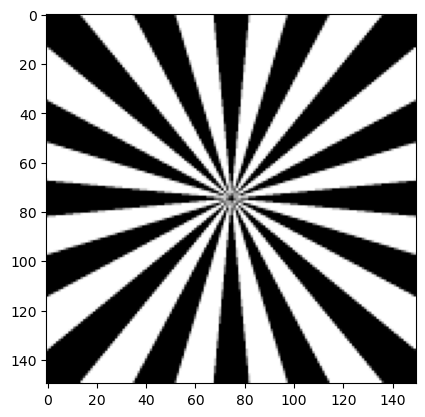

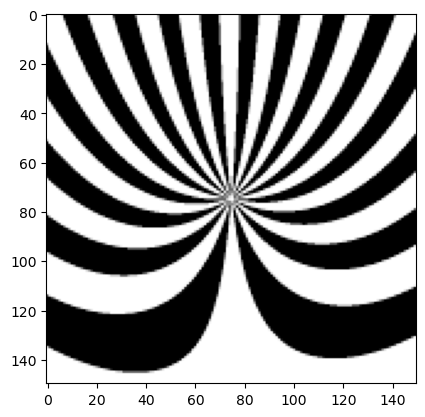

In [2]:
test_movie = './siemens_star/Rolling_Shutter_rotating_Siemens_star.gif'

movie = []
with Image.open(test_movie) as im:
    for frame in ImageSequence.Iterator(im):
        frame = np.array(frame)
        if(frame.ndim > 2):
            frame = np.mean(frame,axis=-1)
        movie.append(frame)
        #plt.imshow(frame)
        #plt.show()
#for f in movie:
#    print(f.shape,end='')

movie = np.array(movie)
print(movie.shape)
#cut out the center of the movie for computational savings
movie = movie[0:201,75:225,125:275]
print(movie.shape)
movie = torch.from_numpy(np.array(movie))

plt.imshow(movie[1],cmap='Greys_r')
plt.show()
plt.imshow(movie[-1],cmap='Greys_r')
plt.show()

movie = movie.unsqueeze(0).unsqueeze(0)
movie = movie.float()

## Load in our Spatiotemporal Filter Bank

In [3]:
normalize=False
filter_banks_size = 20
with open(f'./filter_banks_norm{normalize}_{filter_banks_size}/filters_torch.pkl', 'rb') as f:
    filters = pickle.load(f)

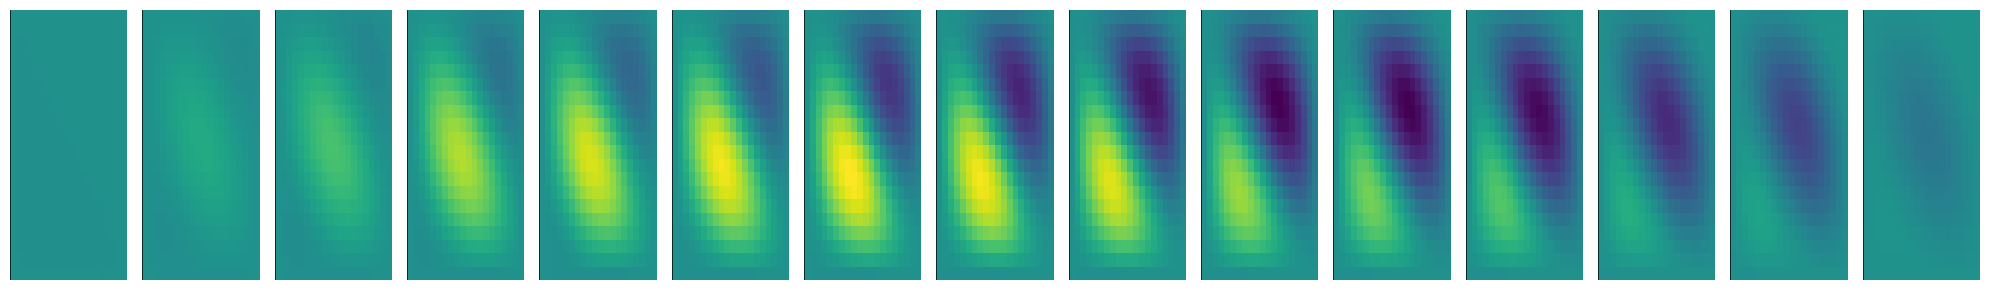

torch.Size([20, 20, 20])


In [4]:
fig = plt.figure(figsize=(20, 3))
afilter = filters['spatiotemporal']['im']['2-0-0']
nslicestot = afilter.shape[0]
vmin = torch.min(afilter)
vmax = torch.max(afilter)
nslices = 15
slices = np.linspace(0,nslicestot-1,nslices,dtype=int)
f=0
for i in slices:
    f+=1
    plt.subplot(1,nslices,f)
    plt.pcolormesh(afilter[i,:,:],vmin=vmin,vmax=vmax)
    plt.axhline(0,color='black',linewidth = 0.5) # x = 0
    plt.axvline(0,color='black',linewidth = 0.5) # y = 0
    plt.axis('off')
plt.tight_layout()
plt.show()
print(afilter.shape)

## Convolve Filer Bank with Test Video

In [5]:
device = torch.device('cuda')
#device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
#device=('cpu')

movie = movie.to(device)

# Separable convolution function
# Define the separable convolution function
def separable_convolution_3d_slow(movie, conv_filter):
    # Perform 1D convolution along each dimension #this works but is slow
    conv_x = F.conv3d(movie, conv_filter, padding=(0, conv_filter.shape[2]//2, 0))
    conv_y = F.conv3d(conv_x, conv_filter.transpose(2, 3), padding=(0, 0, conv_filter.shape[3]//2))
    conv_z = F.conv3d(conv_y, conv_filter.transpose(3, 4), padding=(conv_filter.shape[4]//2, 0, 0))

# # Split the filter into three 1D filters
#     conv_filter_x = conv_filter.squeeze().unsqueeze(1).unsqueeze(2)  # Shape: [60, 1, 1]
#     conv_filter_y = conv_filter.squeeze().unsqueeze(0).unsqueeze(2)  # Shape: [1, 60, 1]
#     conv_filter_z = conv_filter.squeeze().unsqueeze(0).unsqueeze(1)  # Shape: [1, 1, 60]
#     # Perform 1D convolution along each dimension
#     # X dimension
#     conv_x = F.conv3d(movie, conv_filter_x, padding=(0, 0, conv_filter.size(2)//2))
#     # Y dimension
#     conv_y = F.conv3d(conv_x, conv_filter_y, padding=(0, conv_filter.size(1)//2, 0))
#     # Z dimension
#     conv_z = F.conv3d(conv_y, conv_filter_z, padding=(conv_filter.size(0)//2, 0, 0))
#     return conv_z


def separable_convolution_3d(movie, conv_filter):

    # Extract the 1D filters from the 3D filter
    conv_filter_x = conv_filter.squeeze().view(1, 1, -1)  # Shape: [1, 1, 60]
    conv_filter_y = conv_filter.squeeze().view(1, 1, -1)  # Shape: [1, 1, 60]
    conv_filter_z = conv_filter.squeeze().view(1, 1, -1)  # Shape: [1, 1, 60]

    # Perform 1D convolution along each dimension
    # X dimension
    movie = movie.permute(0, 2, 1, 3, 4)  # Shape: [B, D, C, H, W]
    movie = movie.reshape(movie.shape[0] * movie.shape[1], movie.shape[2], -1)  # Shape: [B*D, C, H*W]
    conv_x = F.conv1d(movie, conv_filter_x, padding=conv_filter_x.size(-1) // 2)
    conv_x = conv_x.reshape(-1, movie.shape[1], conv_x.shape[-1] // movie.shape[2], movie.shape[2])  # Shape: [B*D, C, H, W]
    conv_x = conv_x.permute(0, 2, 1, 3)  # Shape: [B*D, H, C, W]
    conv_x = conv_x.reshape(-1, conv_x.shape[2], conv_x.shape[1] * conv_x.shape[3])  # Shape: [B*D*H, C, W]

    # Y dimension
    conv_y = F.conv1d(conv_x, conv_filter_y, padding=conv_filter_y.size(-1) // 2)
    conv_y = conv_y.reshape(-1, conv_x.shape[1], conv_y.shape[-1] // conv_x.shape[2], conv_x.shape[2])  # Shape: [B*D*H, C, W, H]
    conv_y = conv_y.permute(0, 2, 1, 3)  # Shape: [B*D*H, W, C, H]
    conv_y = conv_y.reshape(-1, conv_y.shape[2], conv_y.shape[1] * conv_y.shape[3])  # Shape: [B*D*H*W, C, H]

    # Z dimension
    conv_z = F.conv1d(conv_y, conv_filter_z, padding=conv_filter_z.size(-1) // 2)
    conv_z = conv_z.reshape(-1, conv_y.shape[1], conv_z.shape[-1] // conv_y.shape[2], conv_y.shape[2])  # Shape: [B*D*H*W, C, H, D]
    conv_z = conv_z.permute(0, 2, 1, 3)  # Shape: [B*D*H*W, H, C, D]
    conv_z = conv_z.reshape(movie.shape[0], movie.shape[1], conv_z.shape[1], conv_z.shape[2], conv_z.shape[3])  # Shape: [B, D, H, C, W]

    return conv_z.permute(0, 3, 1, 2, 4)  # Shape: [B, C, D, H, W]


real_filters = []
imag_filters = []
real_outputs = []
imag_outputs = []
filter_names = list(filters['spatiotemporal']['re'].keys())
#loop thorugh filters
for filter_name in filter_names:
    real_filter = filters['spatiotemporal']['re'][filter_name].unsqueeze(0).unsqueeze(0).float()
    imag_filter = filters['spatiotemporal']['im'][filter_name].unsqueeze(0).unsqueeze(0).float()

    real_filter = real_filter.to(device)
    imag_filter = imag_filter.to(device)

    real_filters.append(real_filter)
    imag_filters.append(imag_filter)

    # #shape of filters is [1,1,60,60,60]
    # print(real_filter.type)
    #print(real_filter.shape, imag_filter.shape)
    # #shape of movie is [1,1,201,200,200]
    # print(movie.type)
    #print(movie.shape)
    
    # Convolve
    #full 3d
    real_conv = F.conv3d(movie, real_filter, padding='same')
    imag_conv = F.conv3d(movie, imag_filter, padding='same')
    
    #Separable TODO: Get this working
    #real_conv = separable_convolution_3d(movie, real_filter).squeeze().cpu().numpy()
    #imag_conv = separable_convolution_3d(movie, imag_filter).squeeze().cpu().numpy()
    
    real_outputs.append(real_conv)
    imag_outputs.append(imag_conv)
    print('*',end='')

print('done')

real_filters = torch.stack(real_filters)
imag_filters = torch.stack(imag_filters)
real_outputs = torch.stack(real_outputs)
imag_outputs = torch.stack(imag_outputs)

/state/partition1/slurm_tmp/26525147.0.0/ipykernel_517971/1942374133.py:85: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  real_conv = F.conv3d(movie, real_filter, padding='same')


****************************************************done


In [6]:
# import torch
# import torch.nn.functional as F

# def separable_convolution_3d(movie, conv_filter):
#     # Ensure movie is a tensor with correct shape
#     if len(movie.shape) != 5 or len(conv_filter.shape) != 5:
#         raise ValueError("Input shapes are not correct. Movie should be BCDHW and conv_filter should be BCDHW")

#     # Extract the 1D filters from the 3D filter
#     conv_filter_x = conv_filter.squeeze().view(1, 1, -1)  # Shape: [1, 1, 60]
#     conv_filter_y = conv_filter.squeeze().view(1, 1, -1)  # Shape: [1, 1, 60]
#     conv_filter_z = conv_filter.squeeze().view(1, 1, -1)  # Shape: [1, 1, 60]

#     # Perform 1D convolution along each dimension
#     # X dimension
#     movie = movie.permute(0, 2, 1, 3, 4)  # Shape: [B, D, C, H, W]
#     movie = movie.reshape(movie.shape[0] * movie.shape[1], movie.shape[2], -1)  # Shape: [B*D, C, H*W]
#     conv_x = F.conv1d(movie, conv_filter_x, padding=conv_filter_x.size(-1) // 2)
#     conv_x = conv_x.reshape(-1, movie.shape[1], conv_x.shape[-1] // movie.shape[2], movie.shape[2])  # Shape: [B*D, C, H, W]
#     conv_x = conv_x.permute(0, 2, 1, 3)  # Shape: [B*D, H, C, W]
#     conv_x = conv_x.reshape(-1, conv_x.shape[2], conv_x.shape[1] * conv_x.shape[3])  # Shape: [B*D*H, C, W]

#     # Y dimension
#     conv_y = F.conv1d(conv_x, conv_filter_y, padding=conv_filter_y.size(-1) // 2)
#     conv_y = conv_y.reshape(-1, conv_x.shape[1], conv_y.shape[-1] // conv_x.shape[2], conv_x.shape[2])  # Shape: [B*D*H, C, W, H]
#     conv_y = conv_y.permute(0, 2, 1, 3)  # Shape: [B*D*H, W, C, H]
#     conv_y = conv_y.reshape(-1, conv_y.shape[2], conv_y.shape[1] * conv_y.shape[3])  # Shape: [B*D*H*W, C, H]

#     # Z dimension
#     conv_z = F.conv1d(conv_y, conv_filter_z, padding=conv_filter_z.size(-1) // 2)
#     conv_z = conv_z.reshape(-1, conv_y.shape[1], conv_z.shape[-1] // conv_y.shape[2], conv_y.shape[2])  # Shape: [B*D*H*W, C, H, D]
#     conv_z = conv_z.permute(0, 2, 1, 3)  # Shape: [B*D*H*W, H, C, D]
#     conv_z = conv_z.reshape(movie.shape[0], movie.shape[1], conv_z.shape[1], conv_z.shape[2], conv_z.shape[3])  # Shape: [B, D, H, C, W]

#     return conv_z.permute(0, 3, 1, 2, 4)  # Shape: [B, C, D, H, W]

# # Example usage
# movie = torch.randn(1, 1, 201, 200, 200)
# conv_filter = torch.randn(1, 1, 30, 30, 30)
# output = separable_convolution_3d(movie, conv_filter)
# print(output.shape)


In [7]:
#code to print output as images

# for i in range(len(real_output)):
    
#     fig = plt.figure(figsize=(20, 3))
#     output = real_output[i]
#     nslicestot = output.shape[0]
#     vmin = torch.min(output)
#     vmax = torch.max(output)
#     nslices = 15
#     slices = np.linspace(0,nslicestot-1,nslices,dtype=int)
#     f=0
#     for i in slices:
#         f+=1
#         plt.subplot(1,nslices,f)
#         # print(output.shape)
#         plt.pcolormesh(output[0,0,i,:,:].cpu().numpy(),vmin=vmin,vmax=vmax)
#         #plt.axhline(0,color='black',linewidth = 0.5) # x = 0
#         #plt.axvline(0,color='black',linewidth = 0.5) # y = 0
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

1-0-0


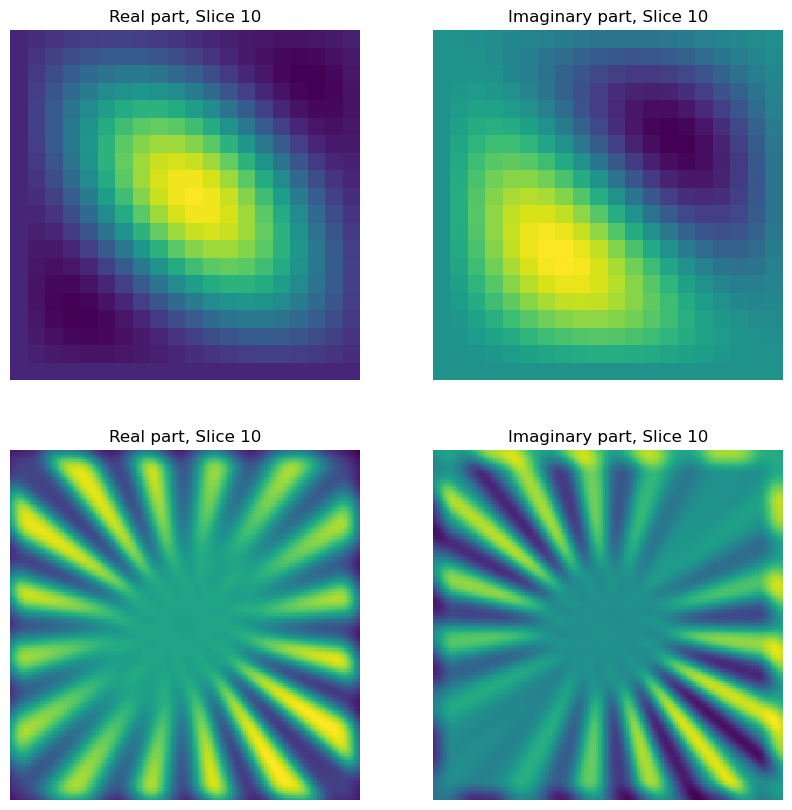

1-0-0.7853981633974483


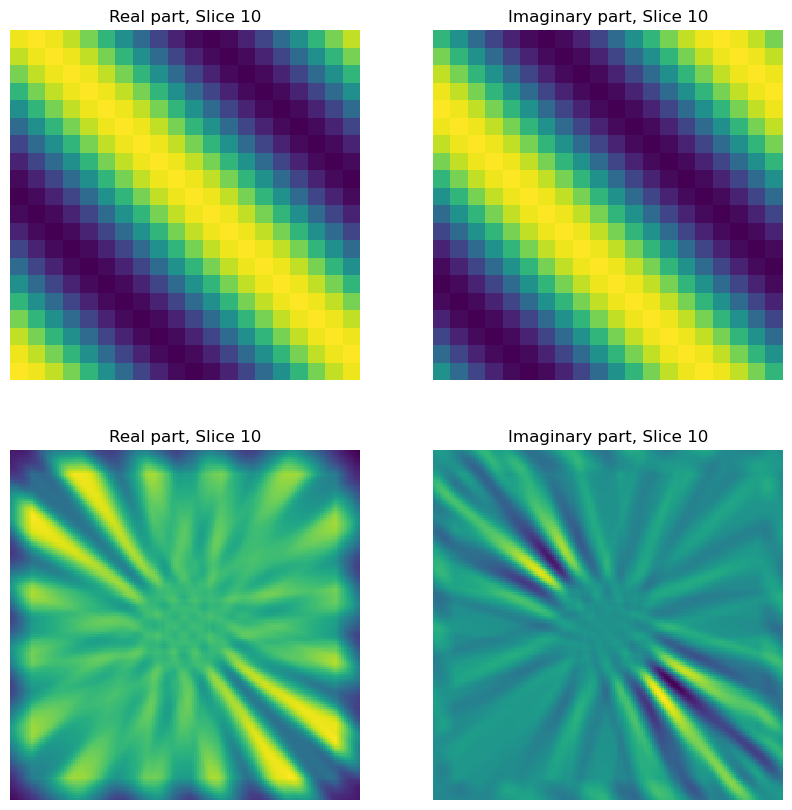

1-0-1.5707963267948966


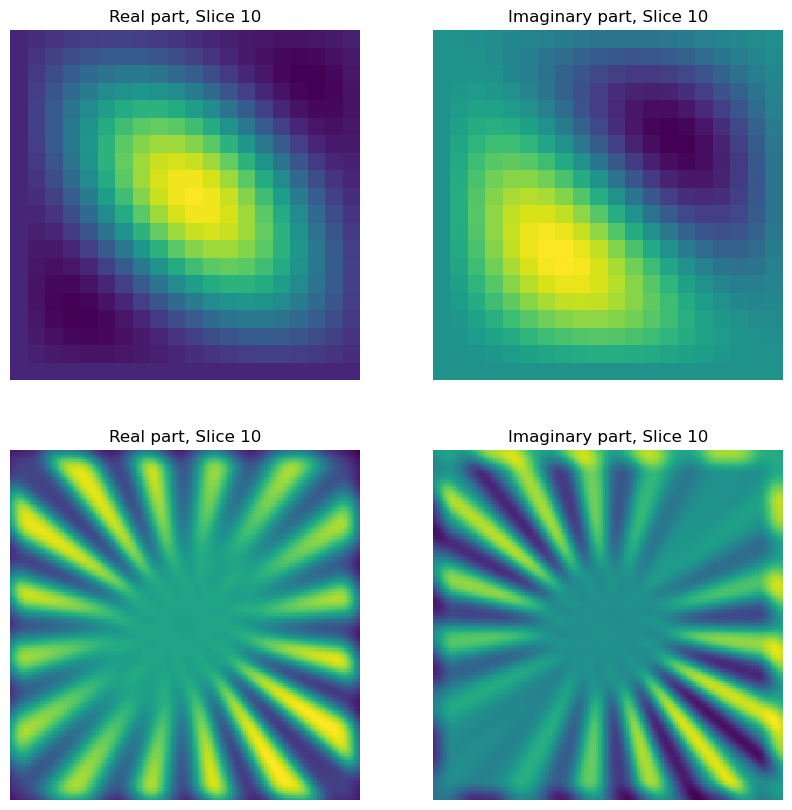

1-0-2.356194490192345


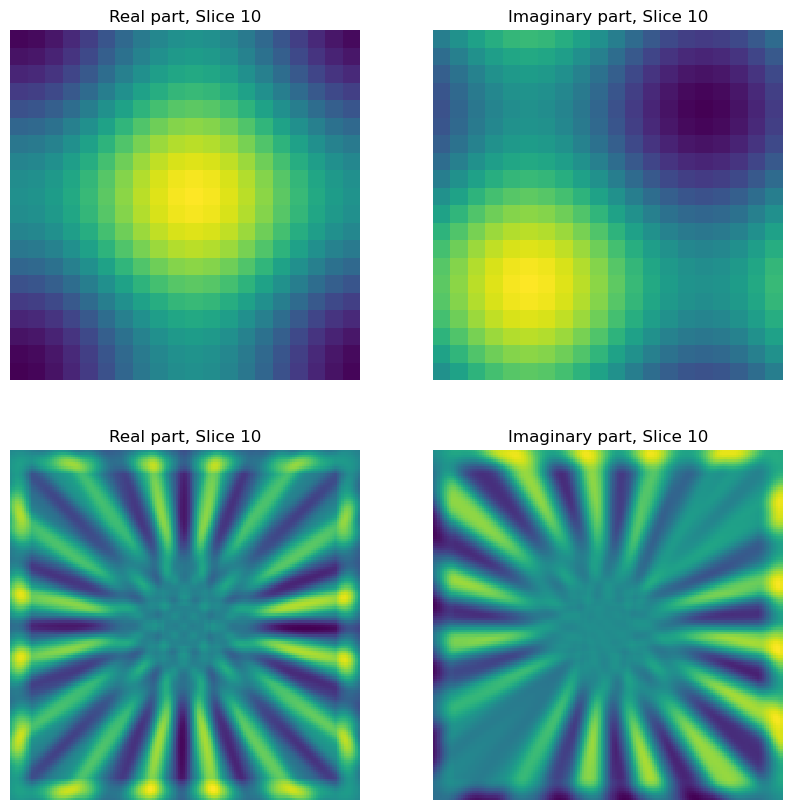

1-0.7853981633974483-0.7853981633974483


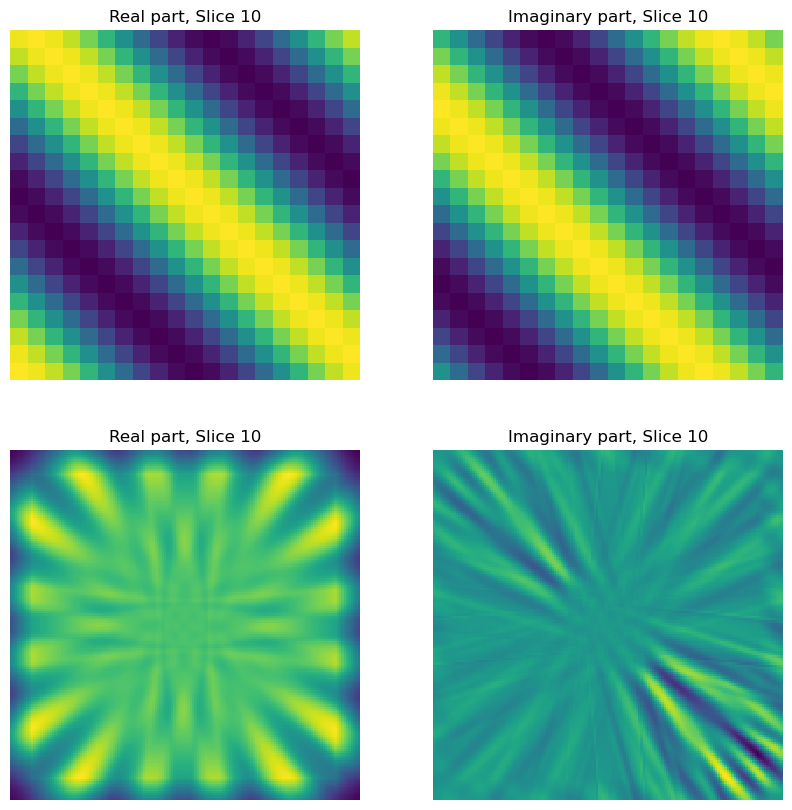

1-0.7853981633974483-1.5707963267948966


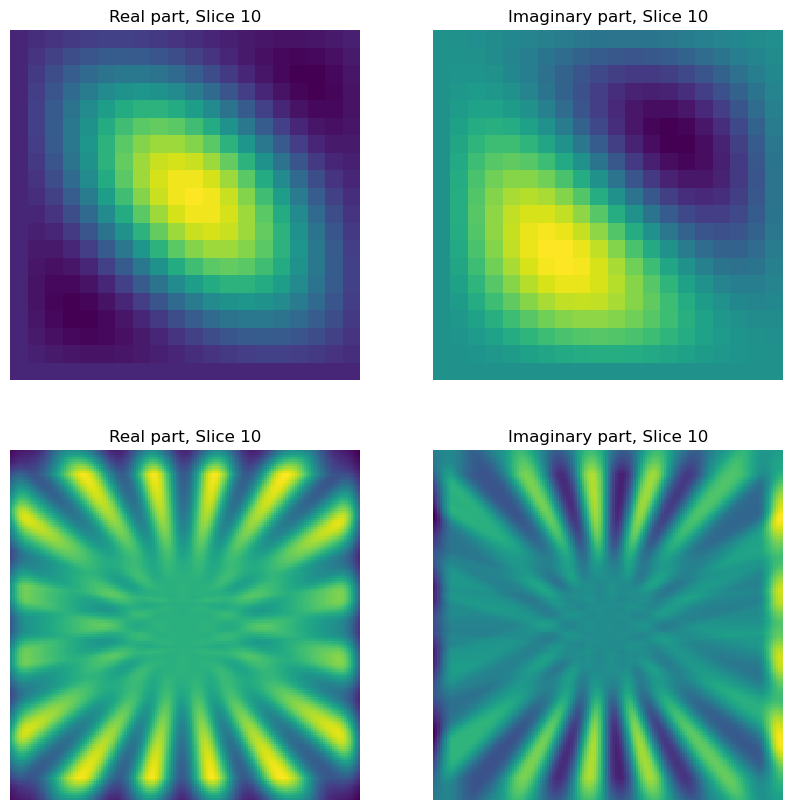

1-0.7853981633974483-2.356194490192345


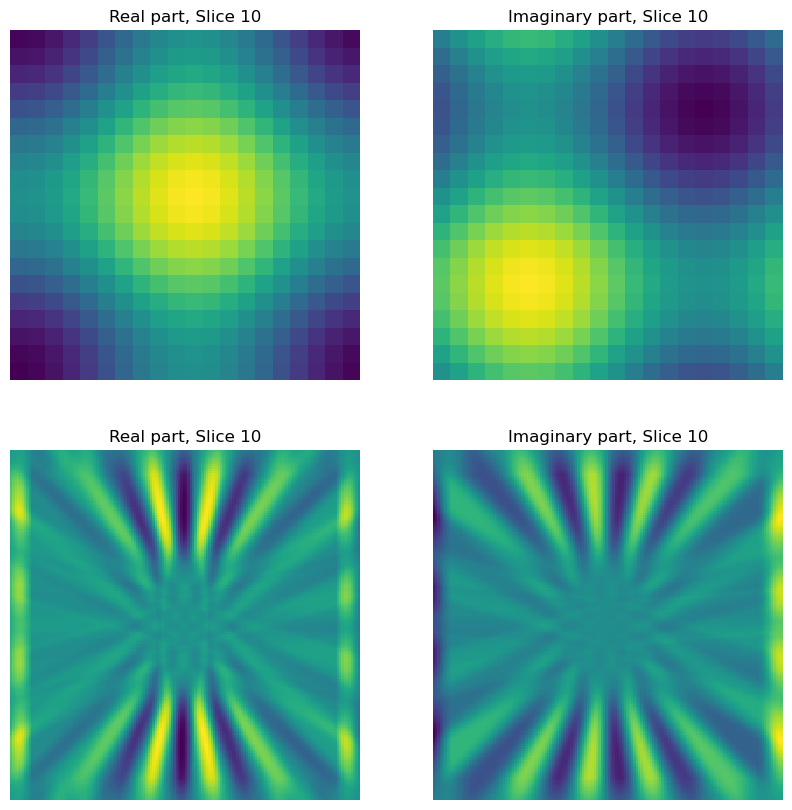

1-1.5707963267948966-0.7853981633974483


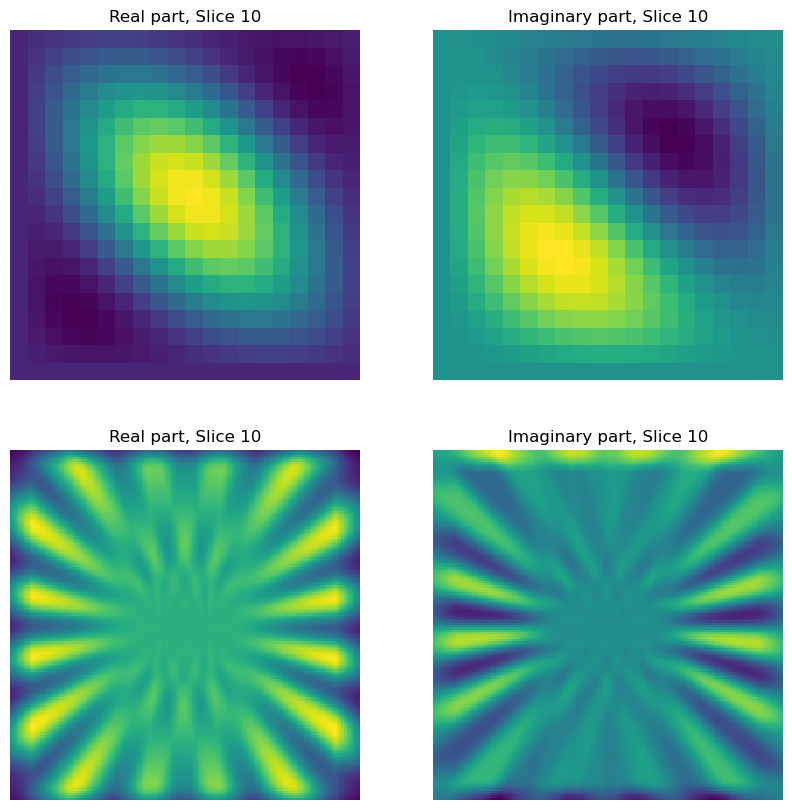

1-1.5707963267948966-1.5707963267948966


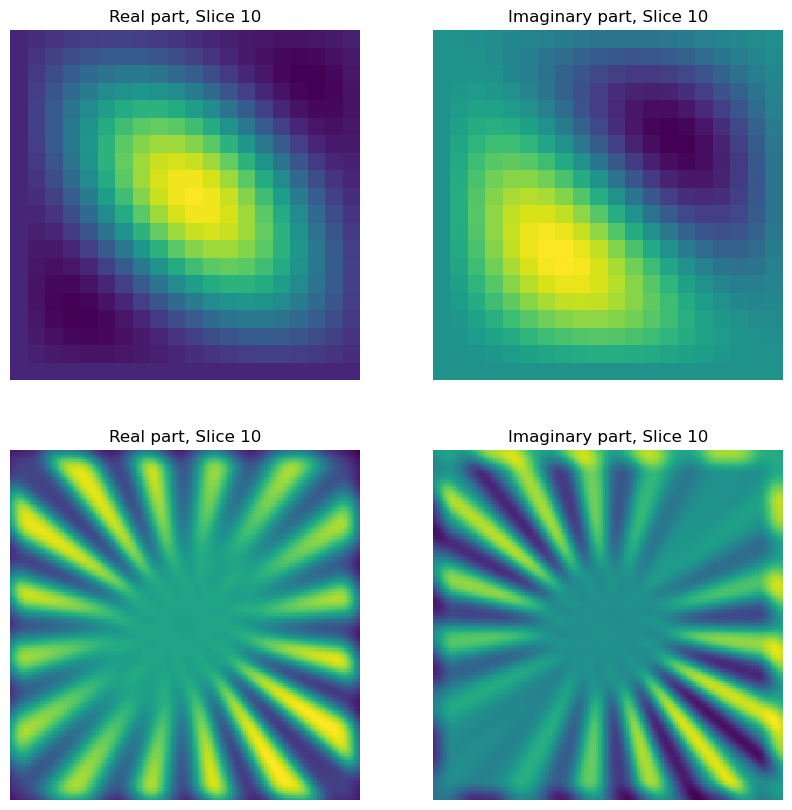

1-1.5707963267948966-2.356194490192345


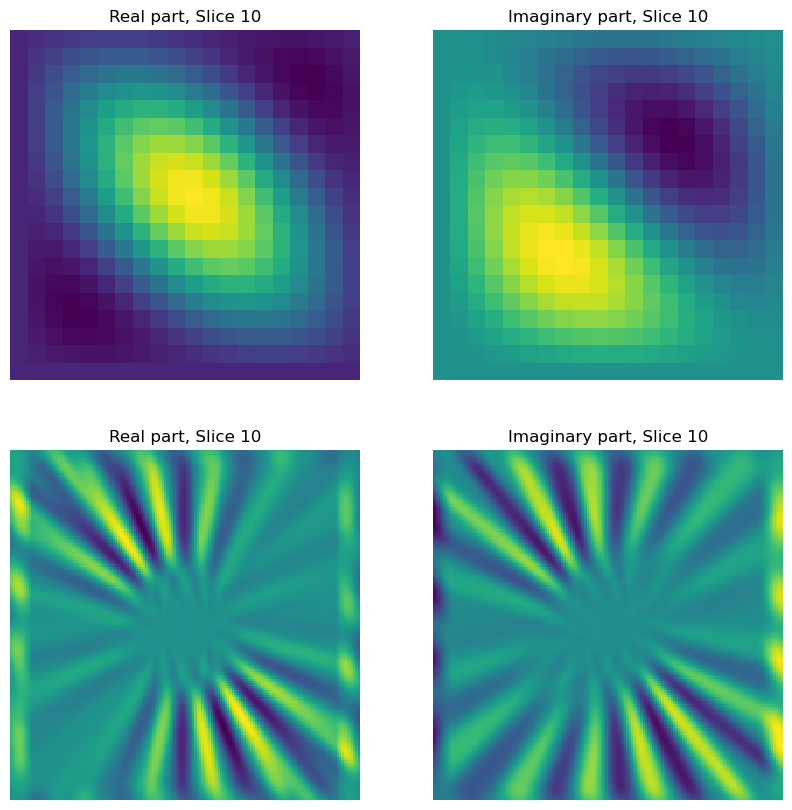

1-2.356194490192345-0.7853981633974483


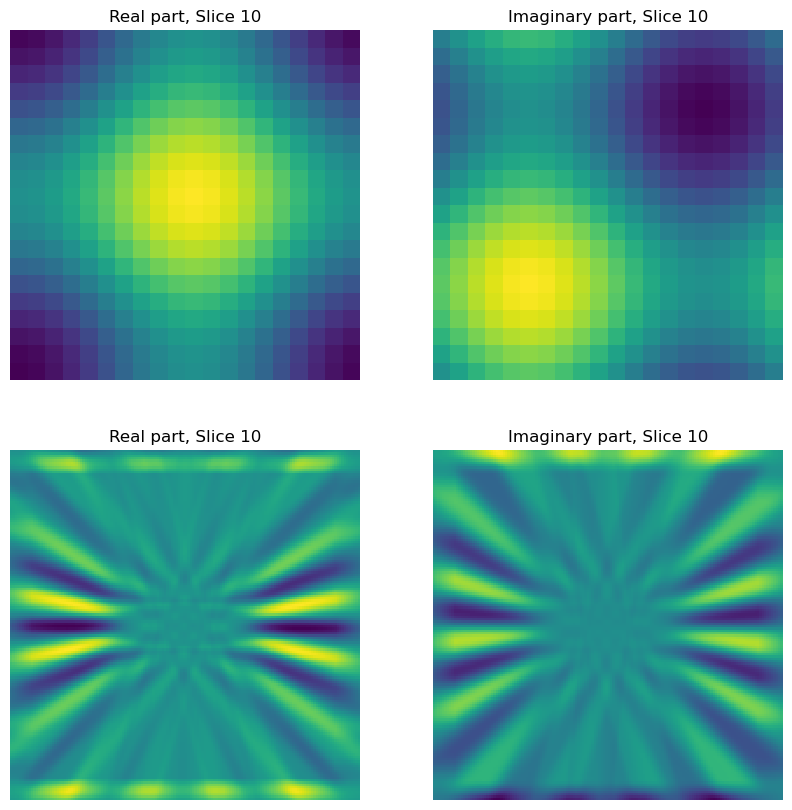

1-2.356194490192345-1.5707963267948966


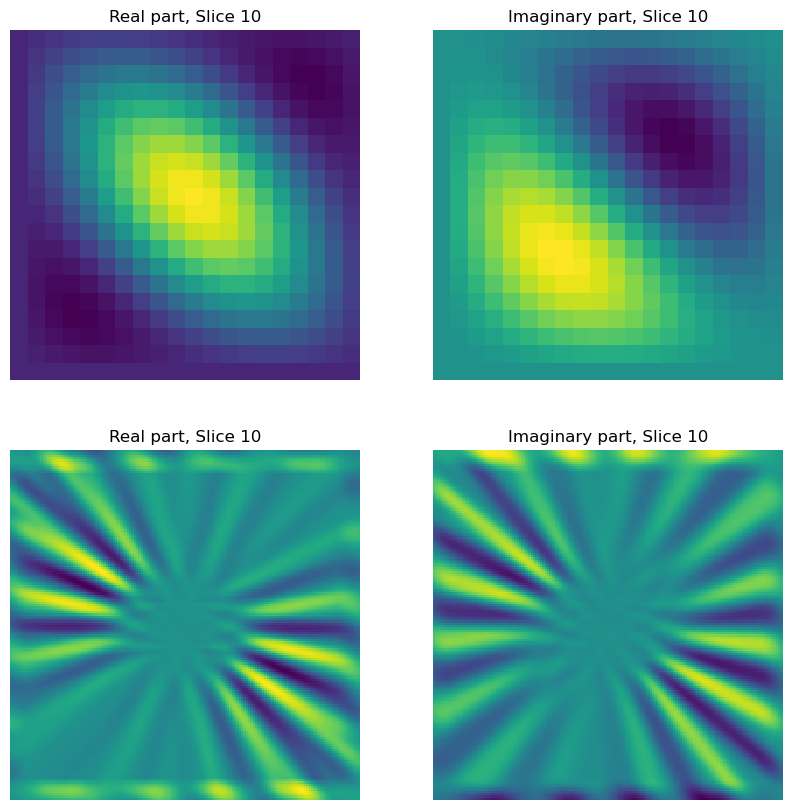

1-2.356194490192345-2.356194490192345


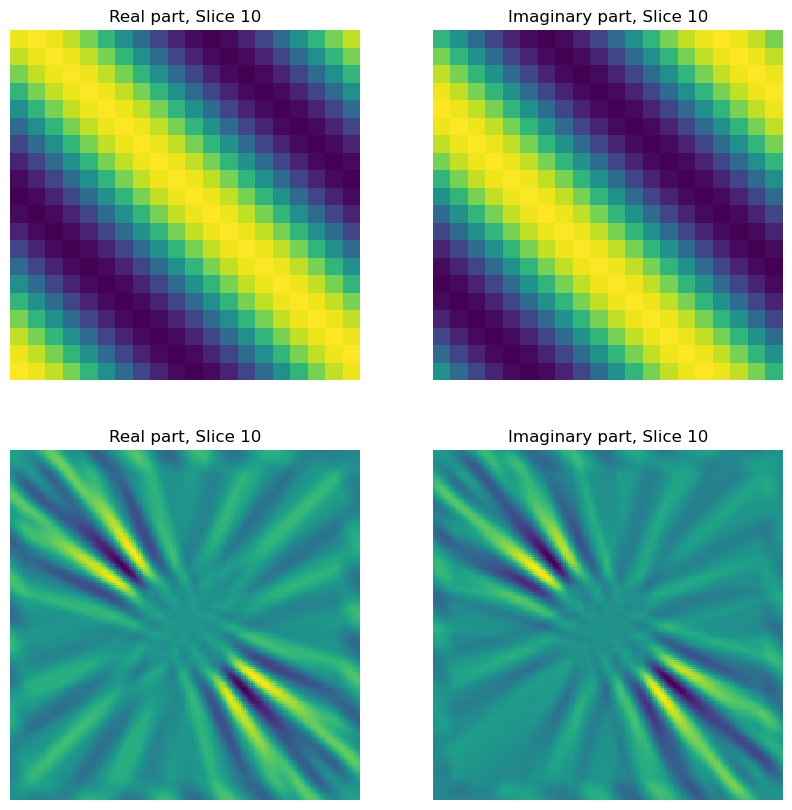

2-0-0


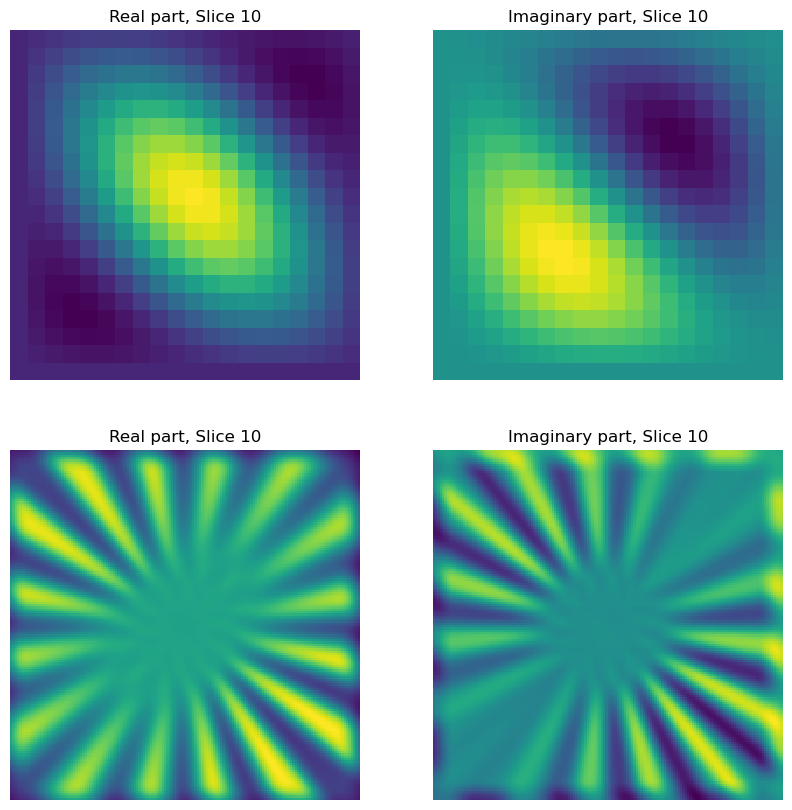

2-0-0.7853981633974483


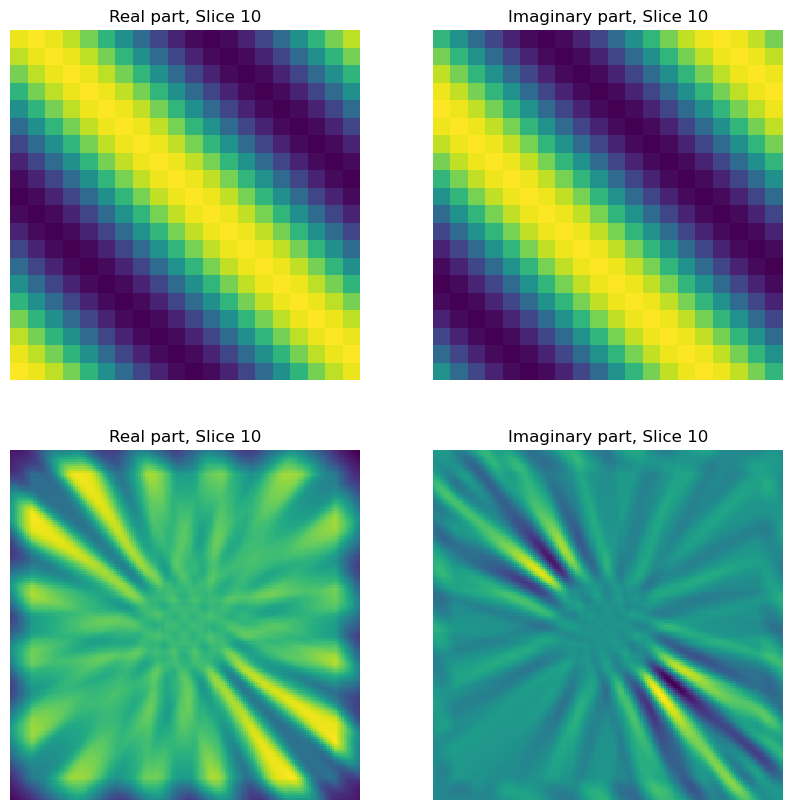

2-0-1.5707963267948966


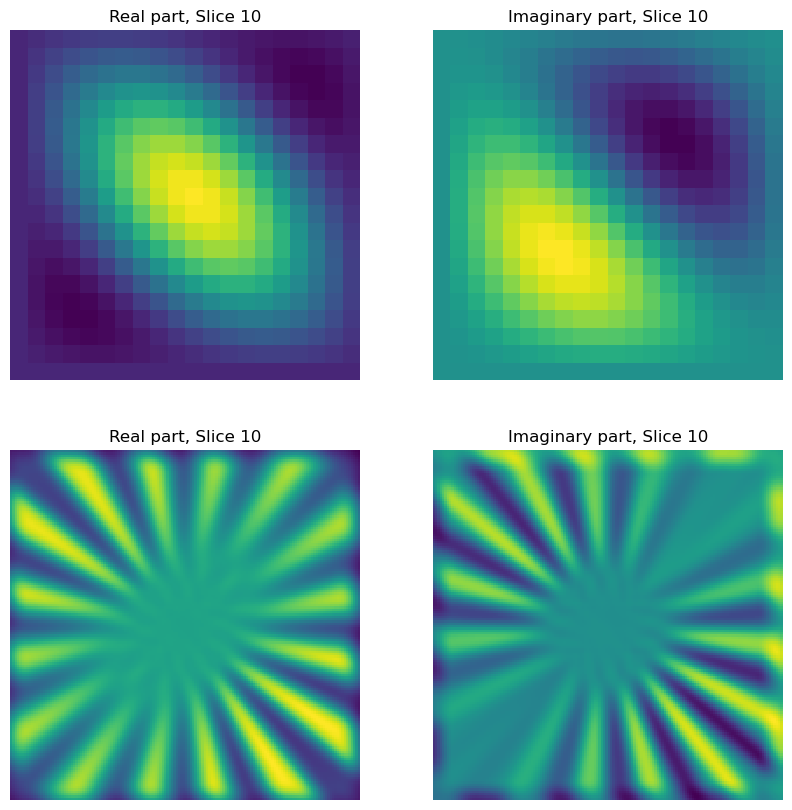

2-0-2.356194490192345


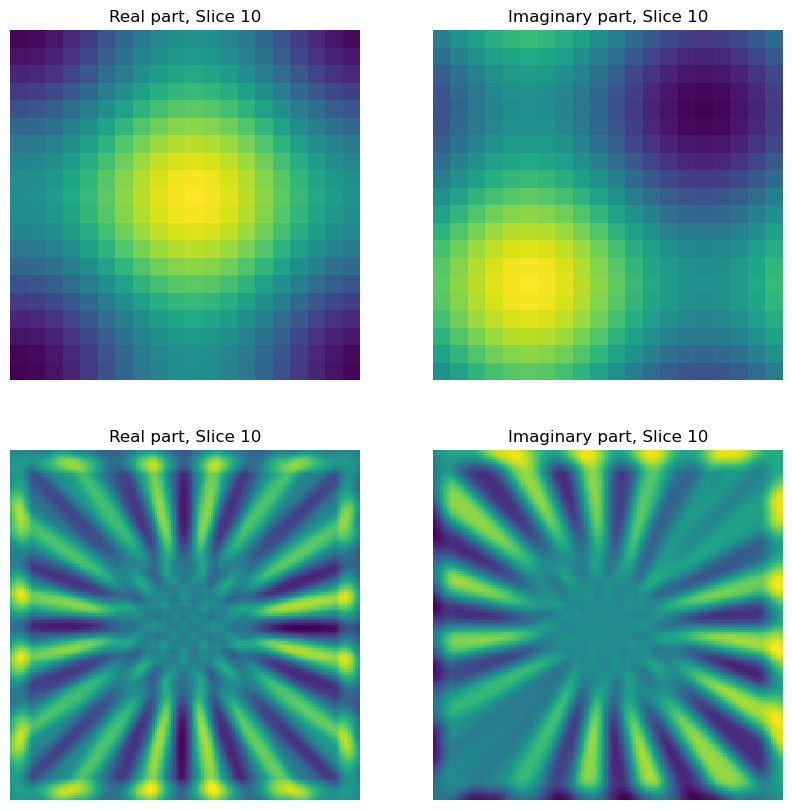

2-0.7853981633974483-0.7853981633974483


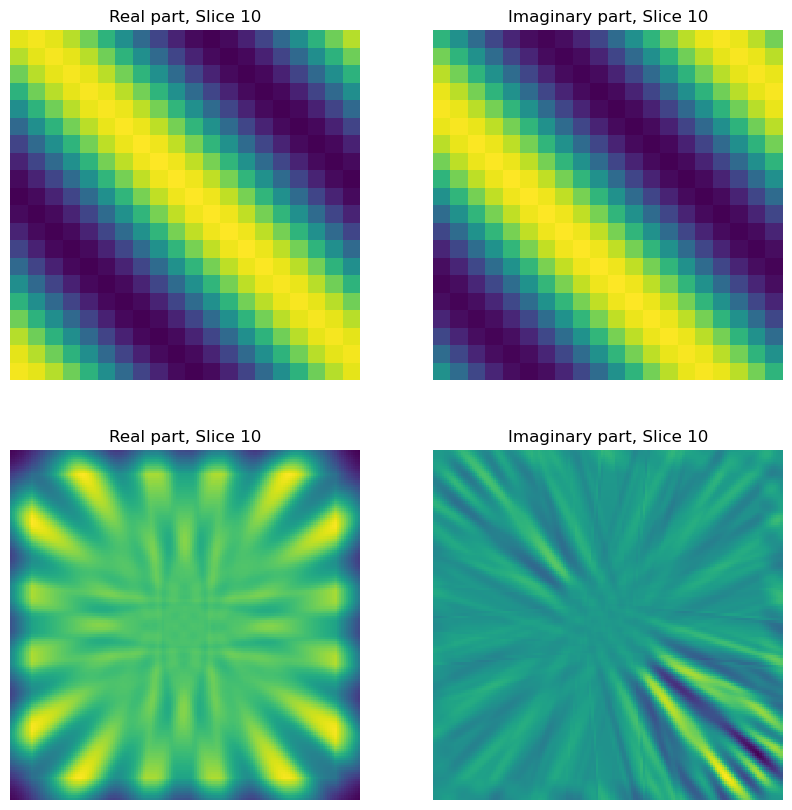

2-0.7853981633974483-1.5707963267948966


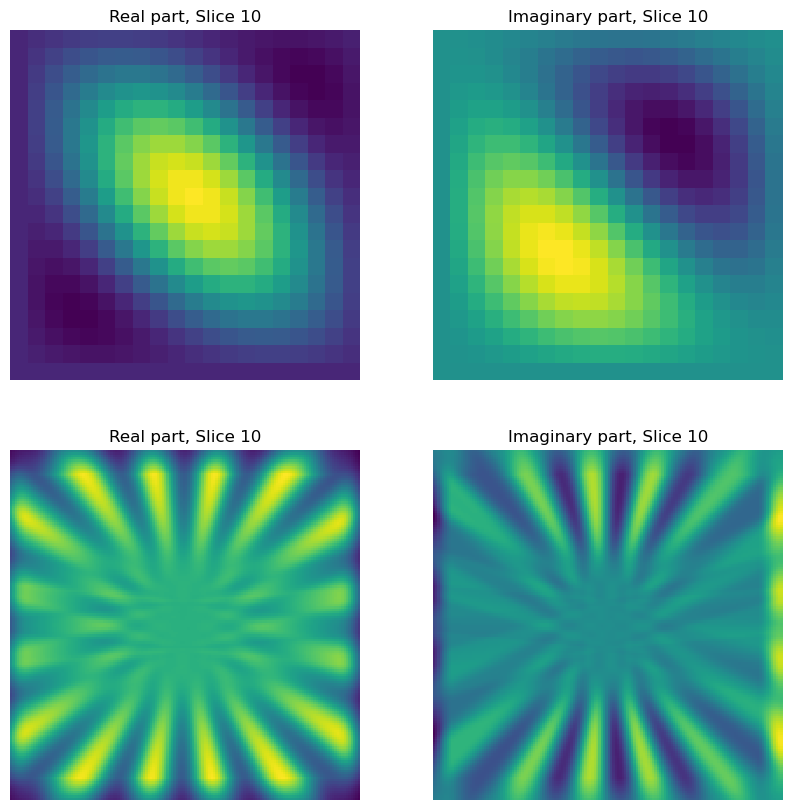

2-0.7853981633974483-2.356194490192345


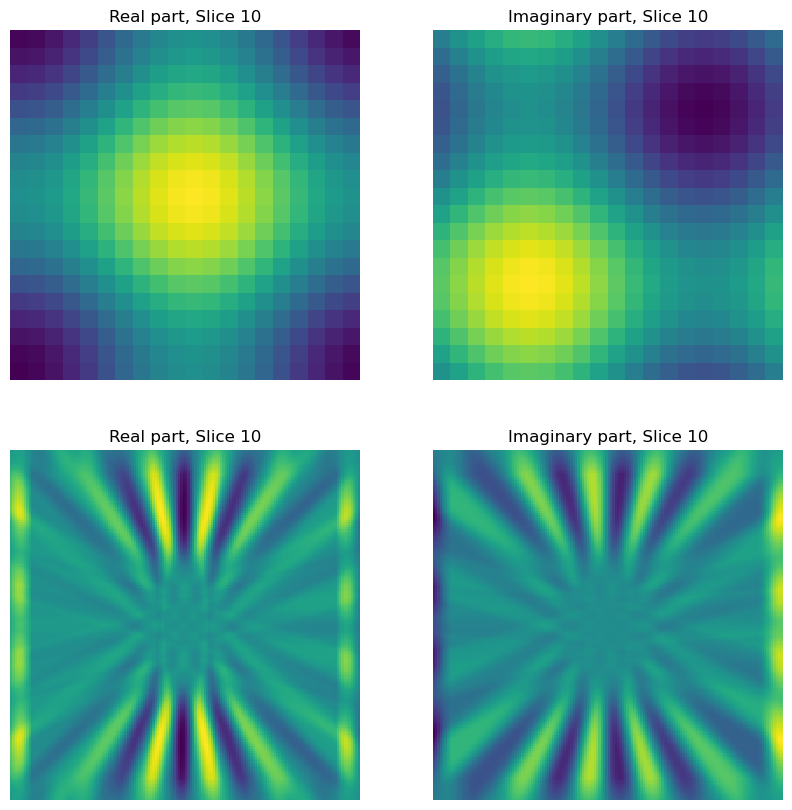

2-1.5707963267948966-0.7853981633974483


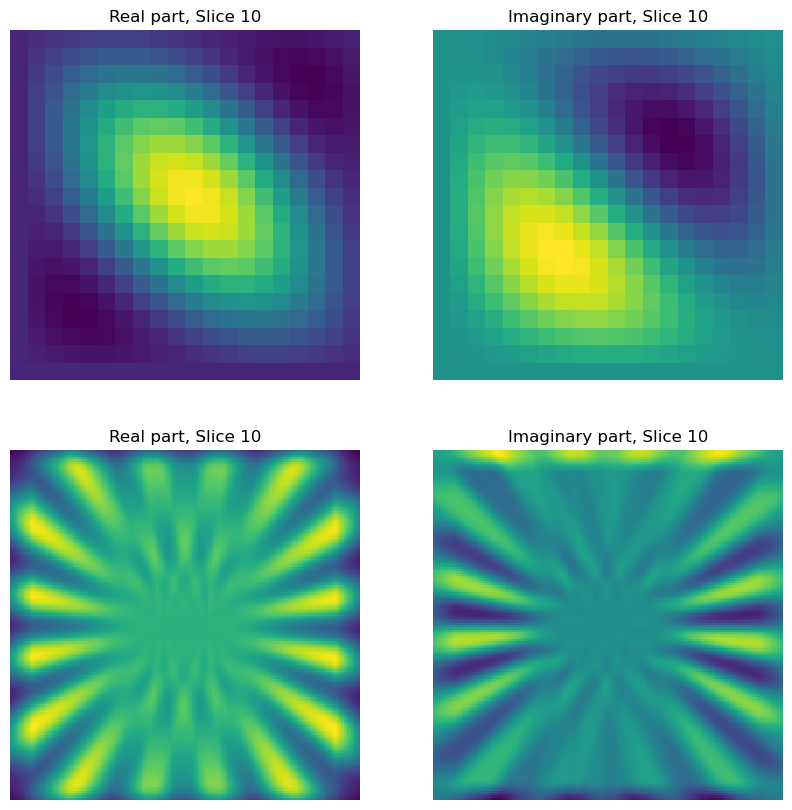

2-1.5707963267948966-1.5707963267948966


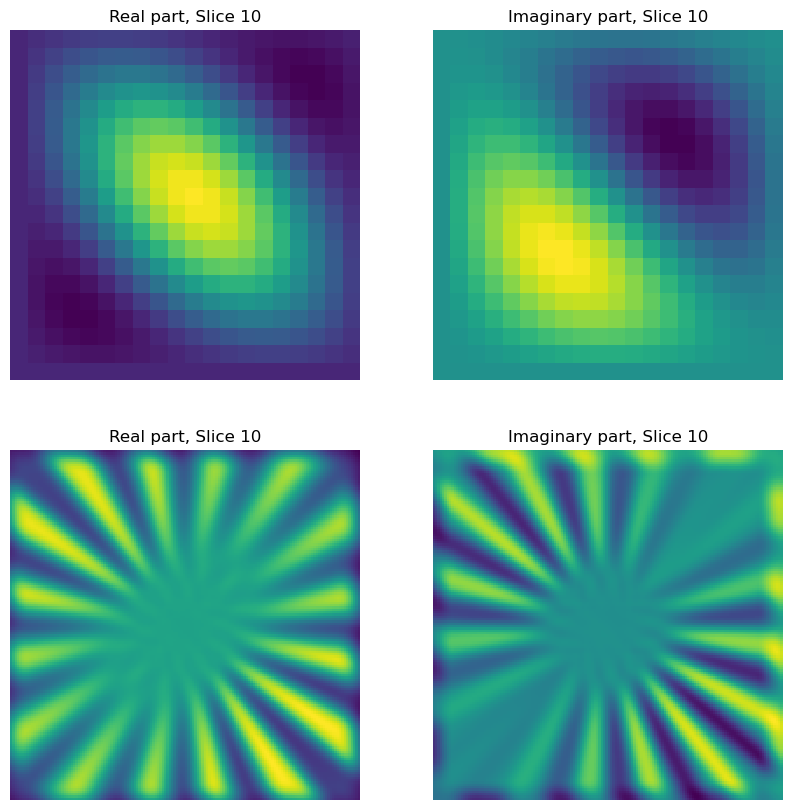

2-1.5707963267948966-2.356194490192345


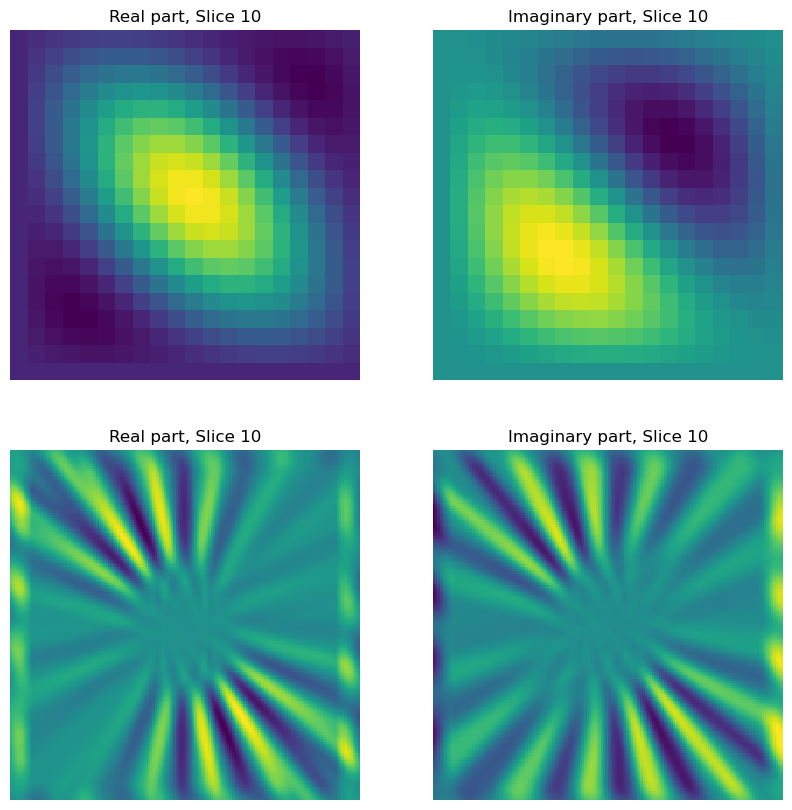

2-2.356194490192345-0.7853981633974483


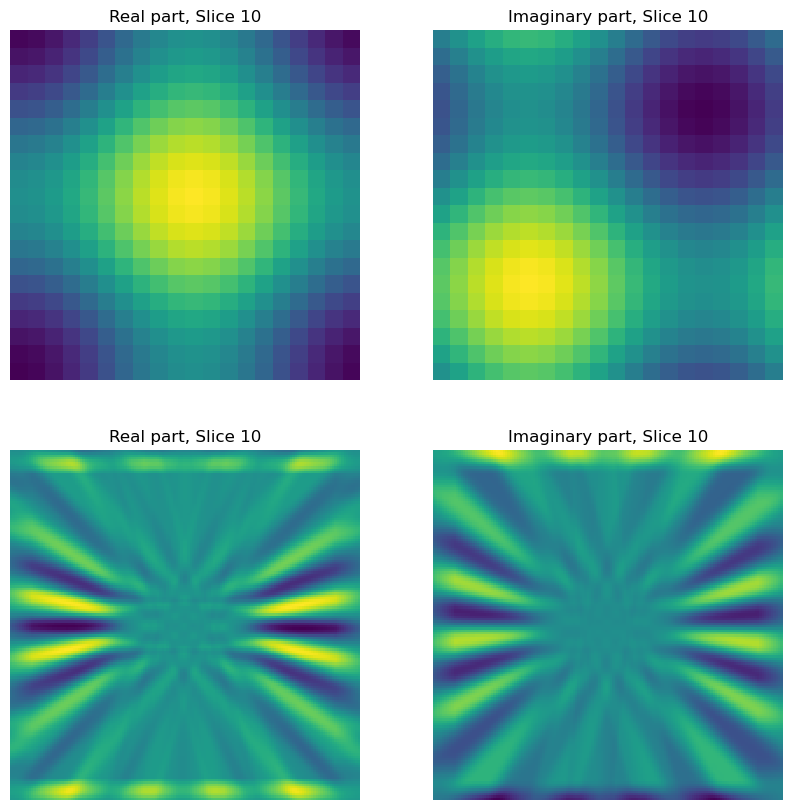

2-2.356194490192345-1.5707963267948966


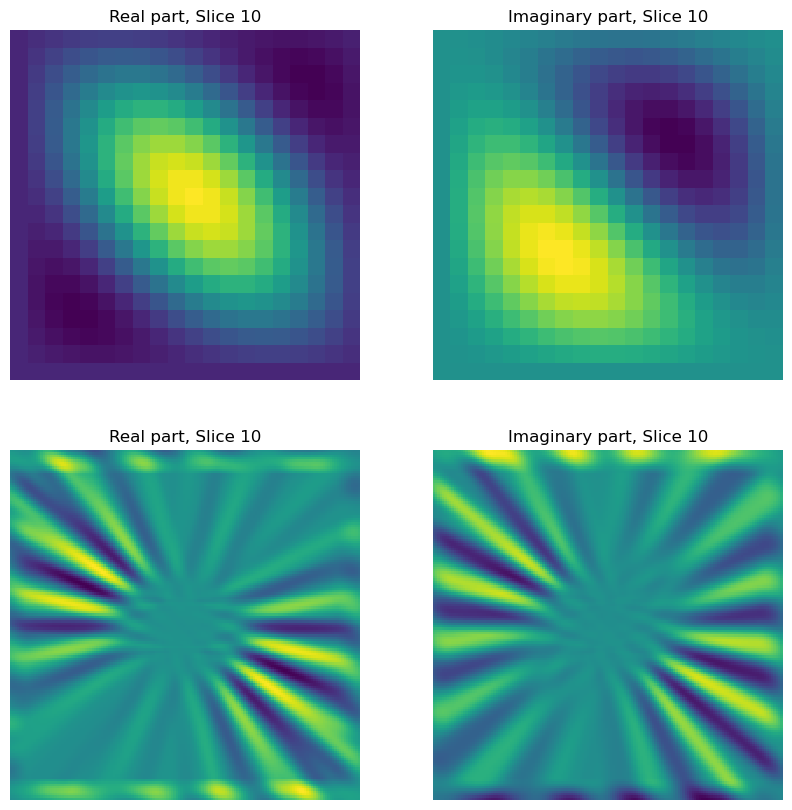

2-2.356194490192345-2.356194490192345


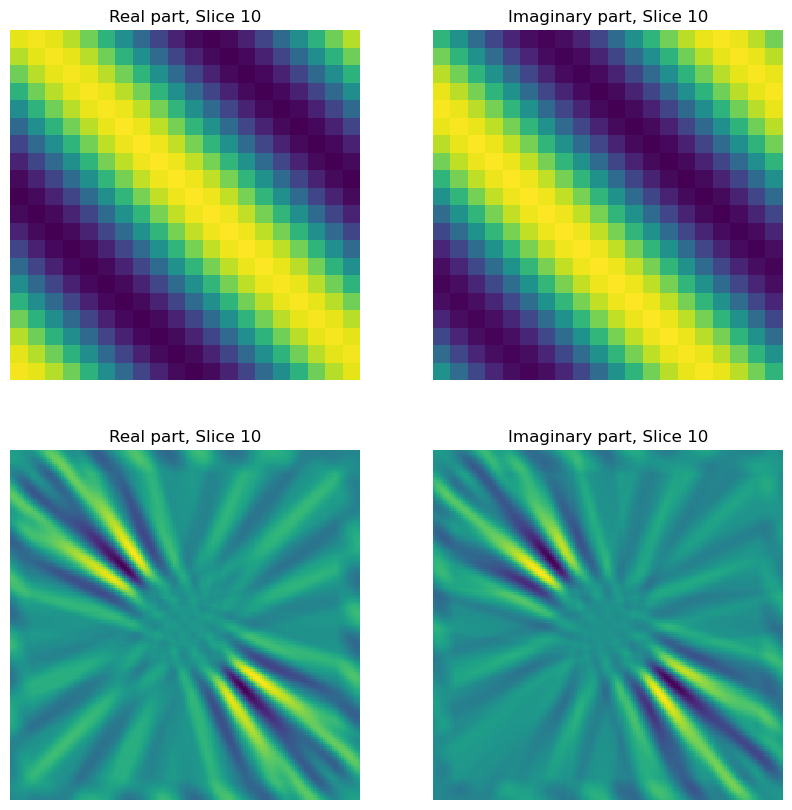

4-0-0


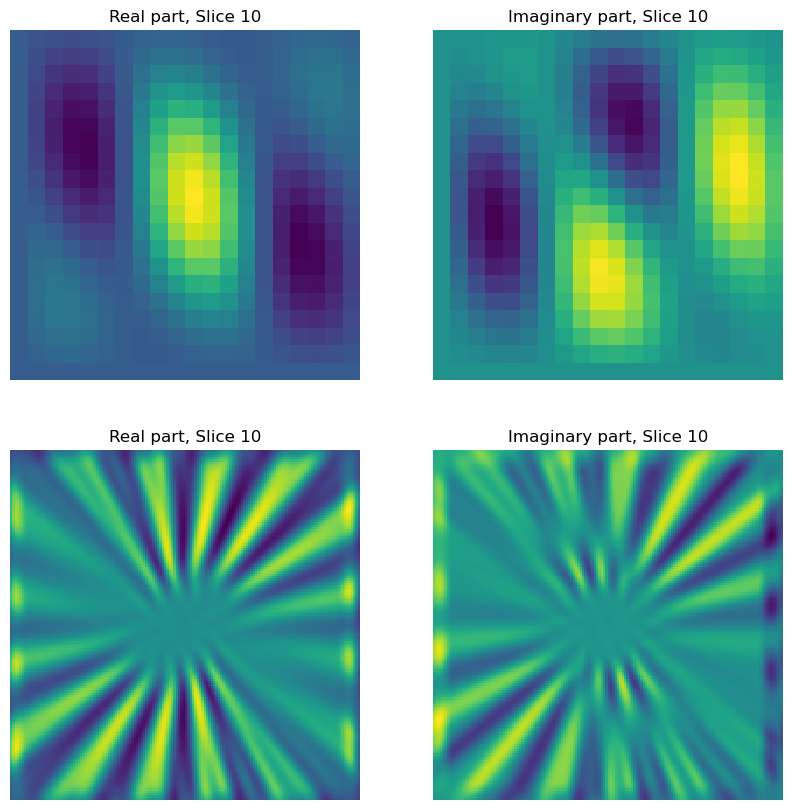

4-0-0.7853981633974483


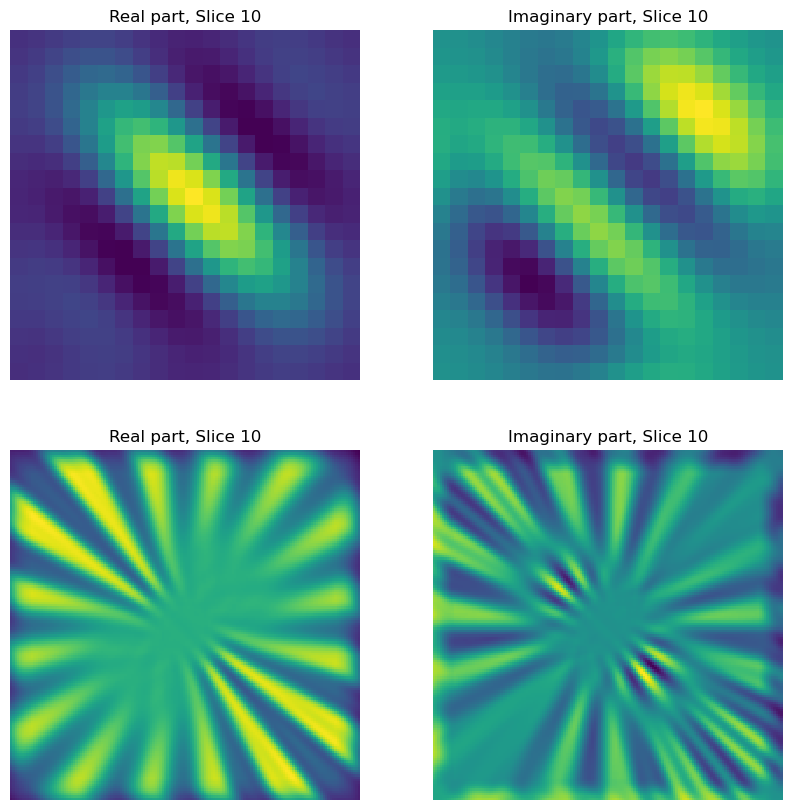

4-0-1.5707963267948966


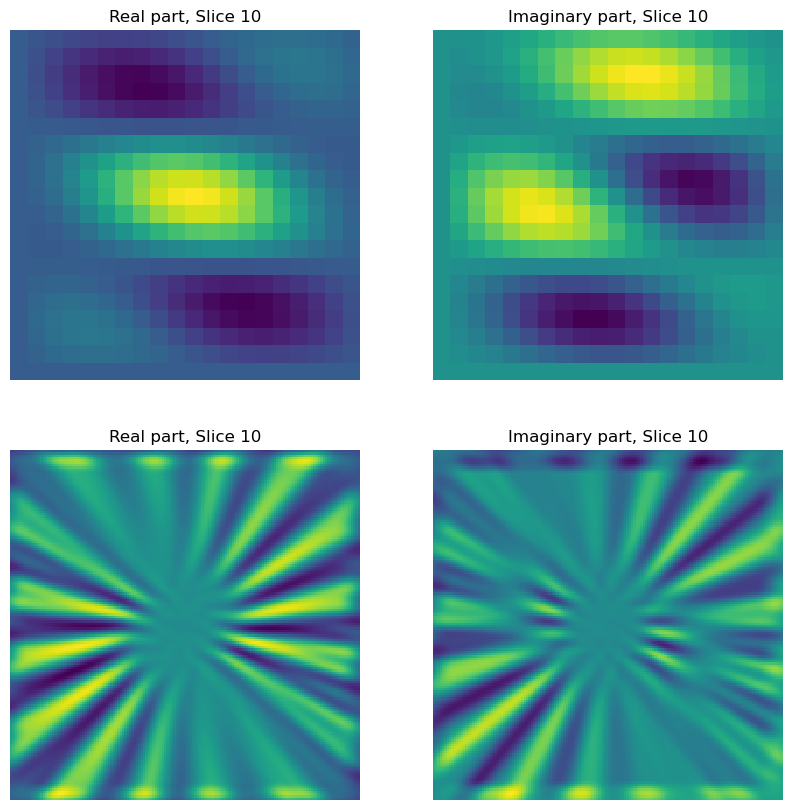

4-0-2.356194490192345


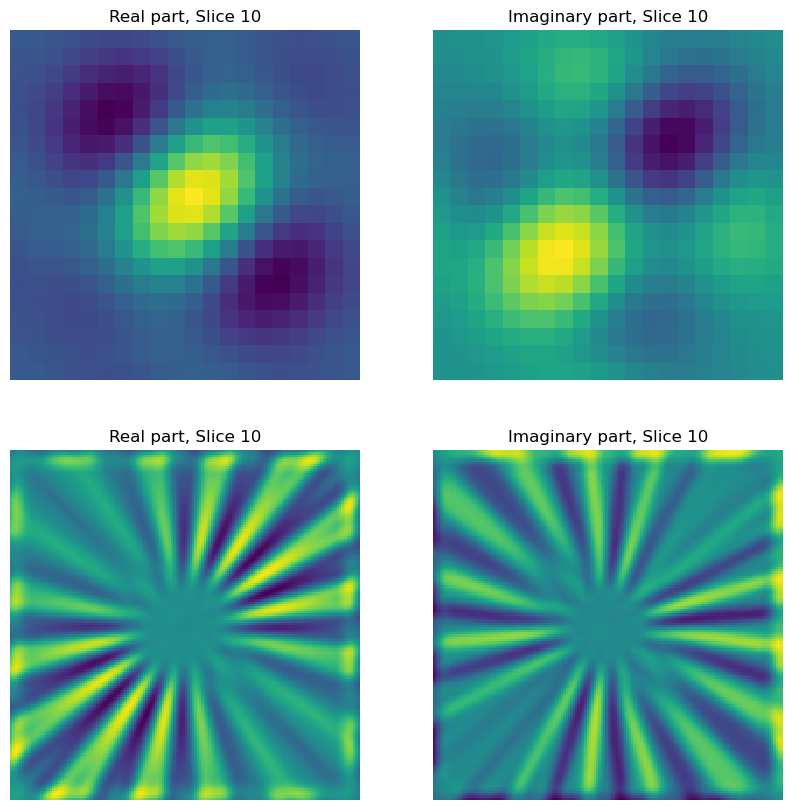

4-0.7853981633974483-0.7853981633974483


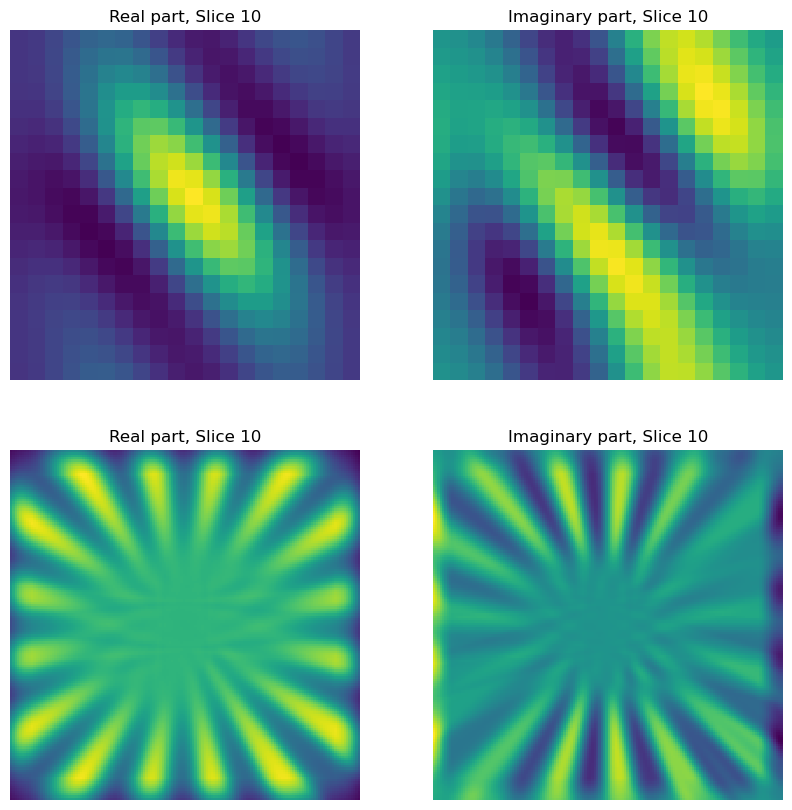

4-0.7853981633974483-1.5707963267948966


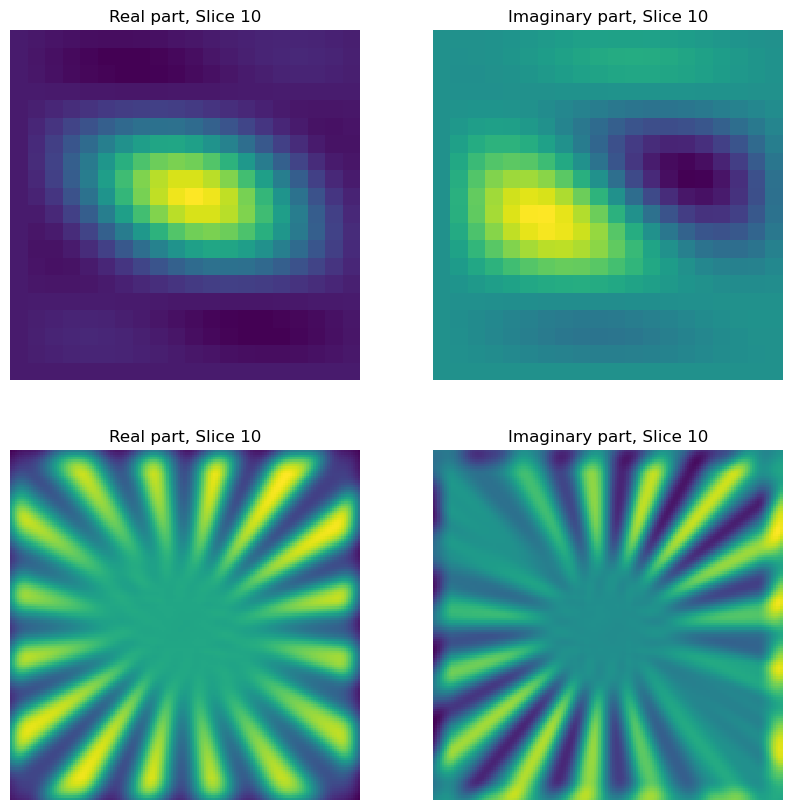

4-0.7853981633974483-2.356194490192345


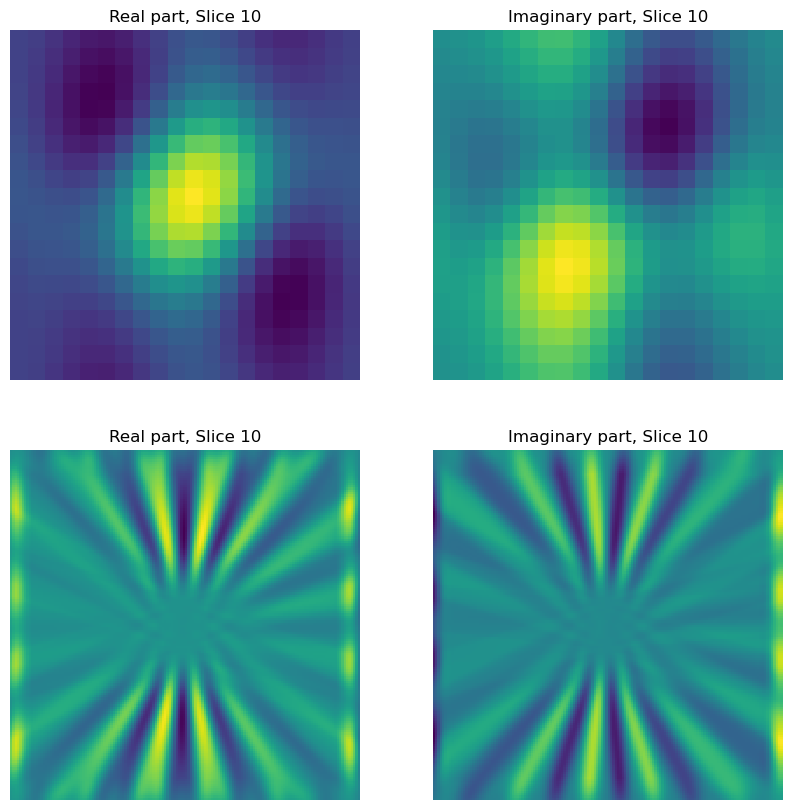

4-1.5707963267948966-0.7853981633974483


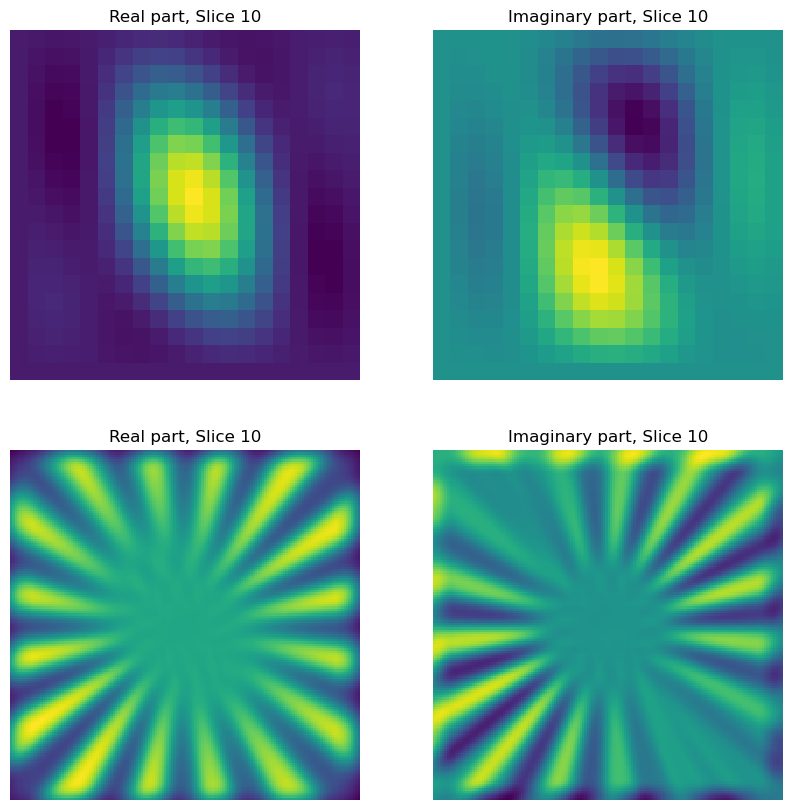

4-1.5707963267948966-1.5707963267948966


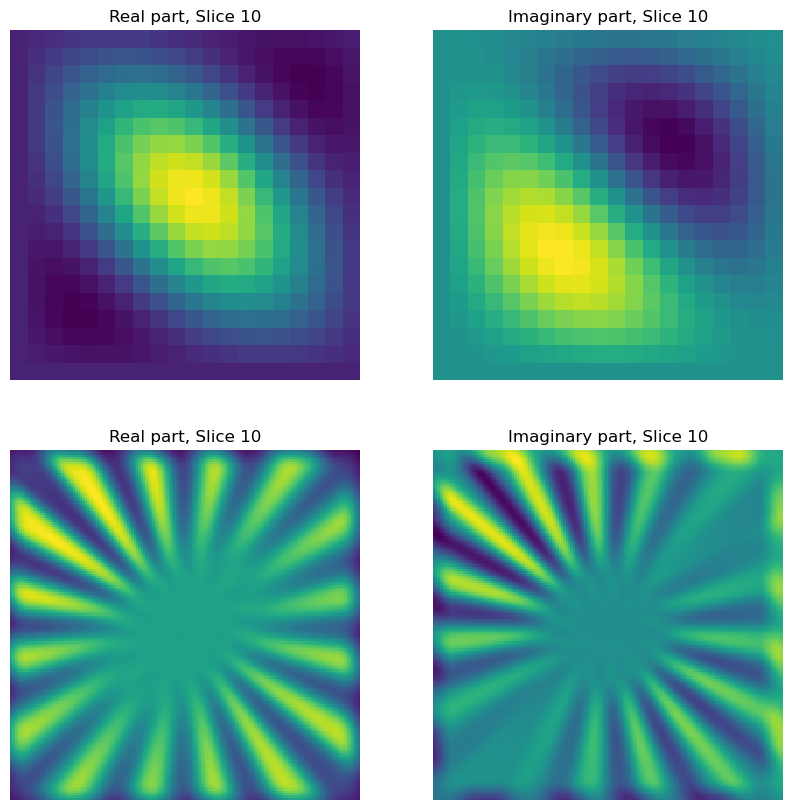

4-1.5707963267948966-2.356194490192345


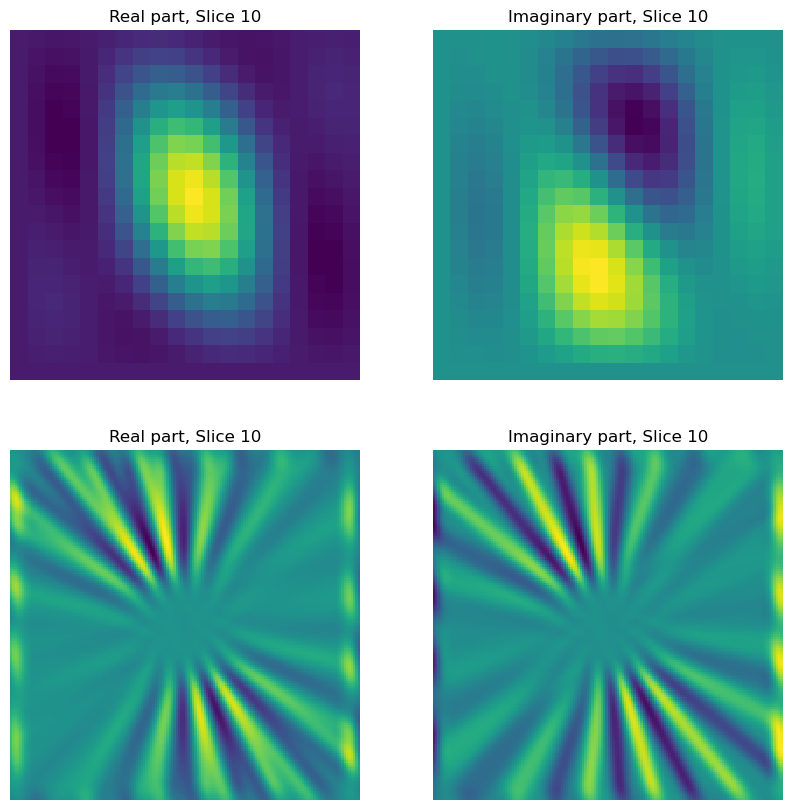

4-2.356194490192345-0.7853981633974483


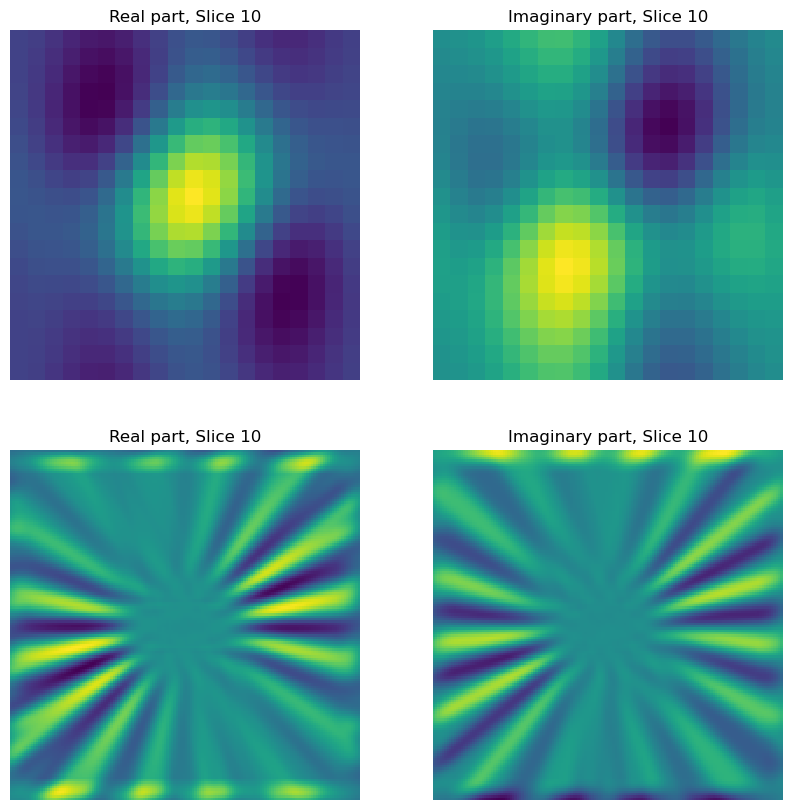

4-2.356194490192345-1.5707963267948966


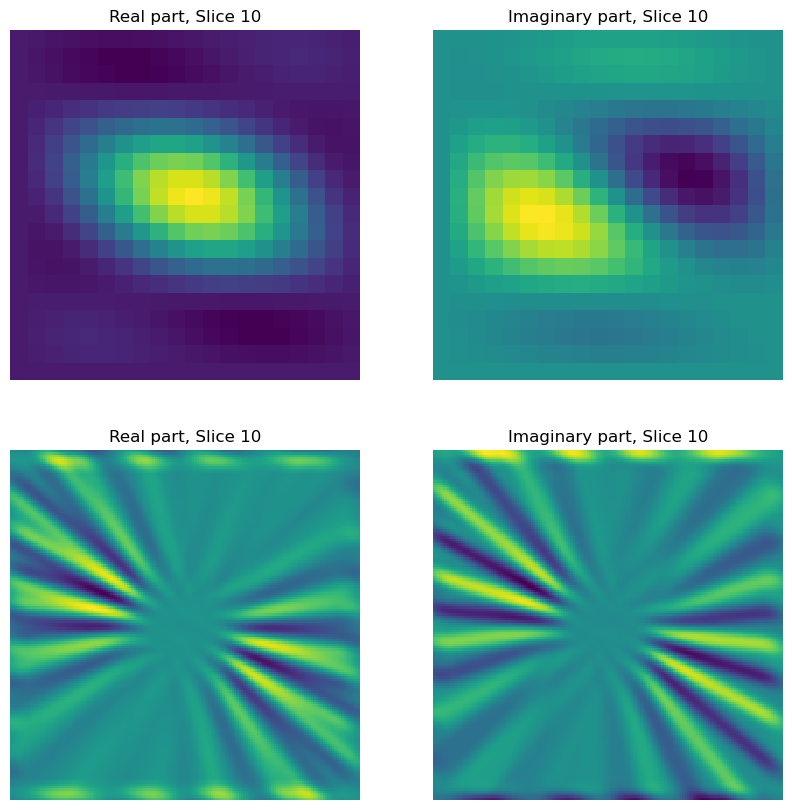

4-2.356194490192345-2.356194490192345


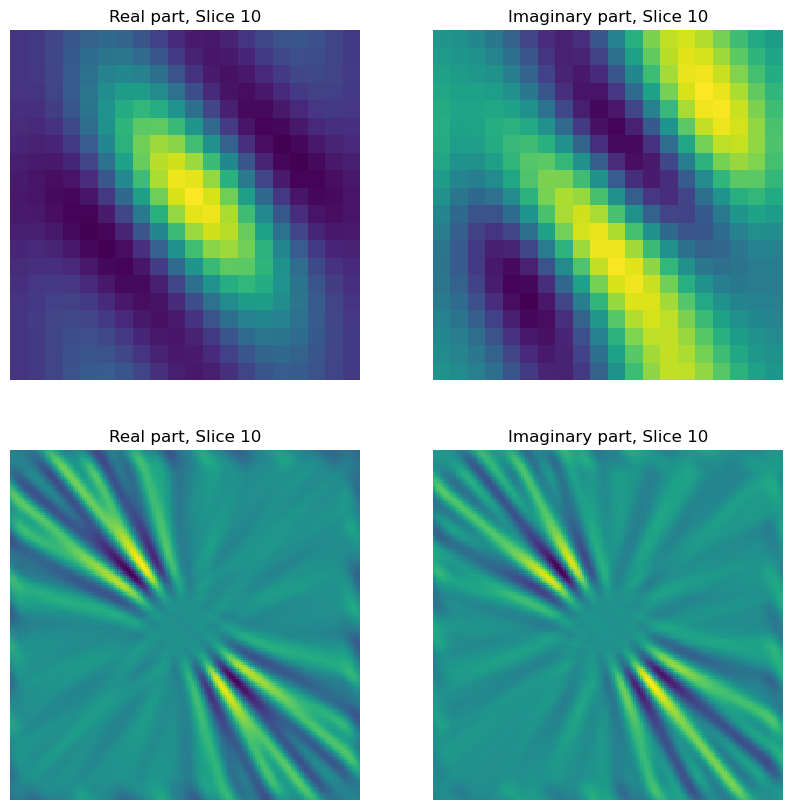

8-0-0


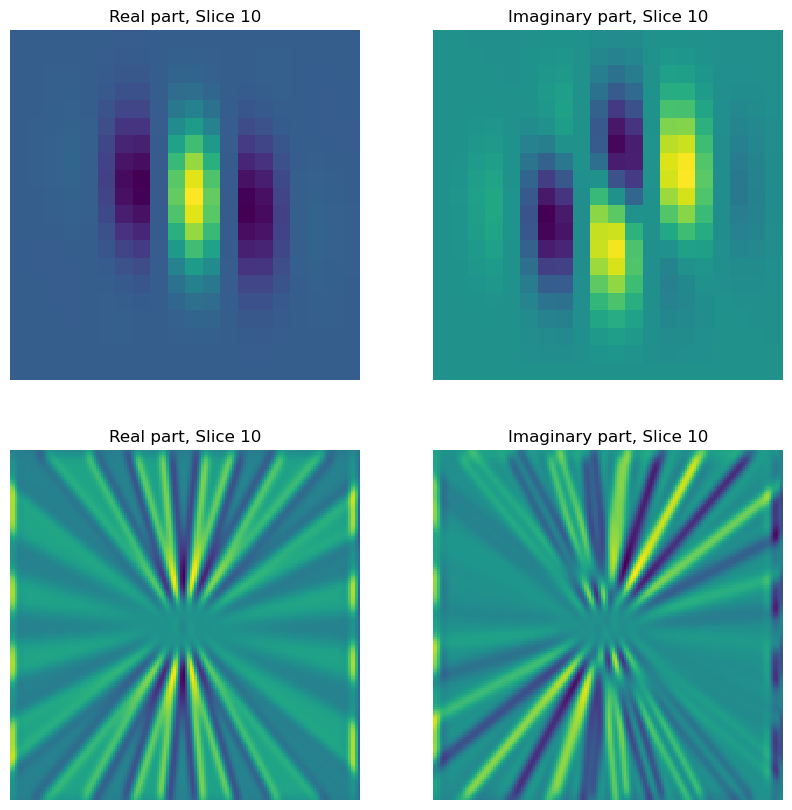

8-0-0.7853981633974483


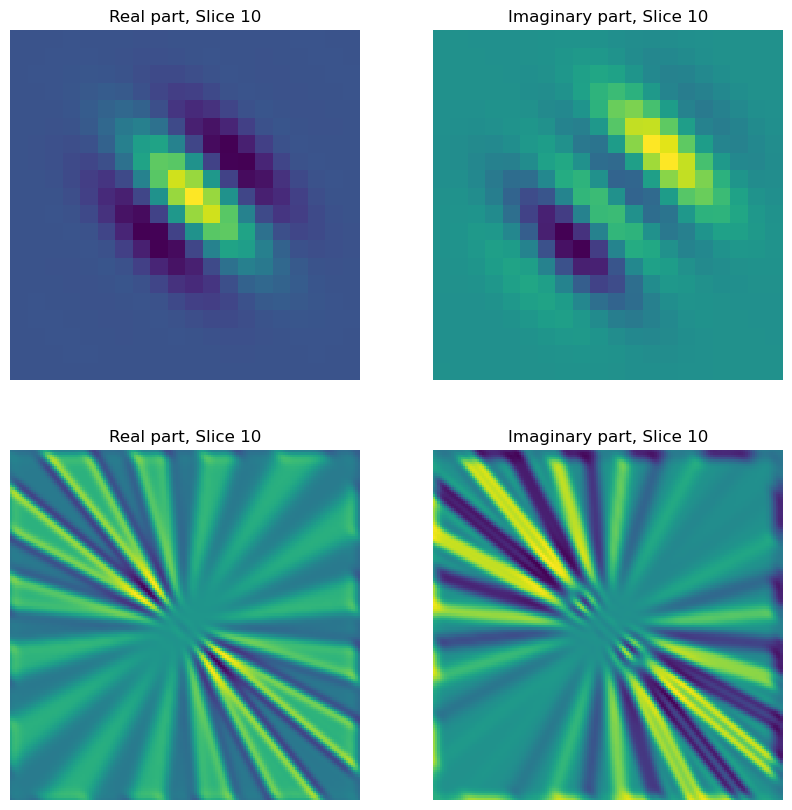

8-0-1.5707963267948966


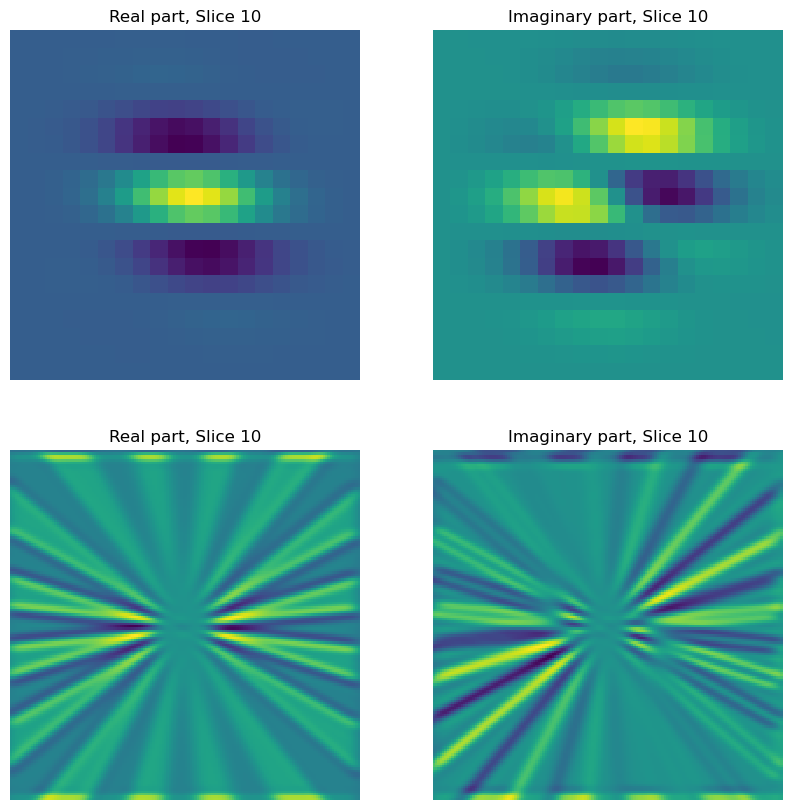

8-0-2.356194490192345


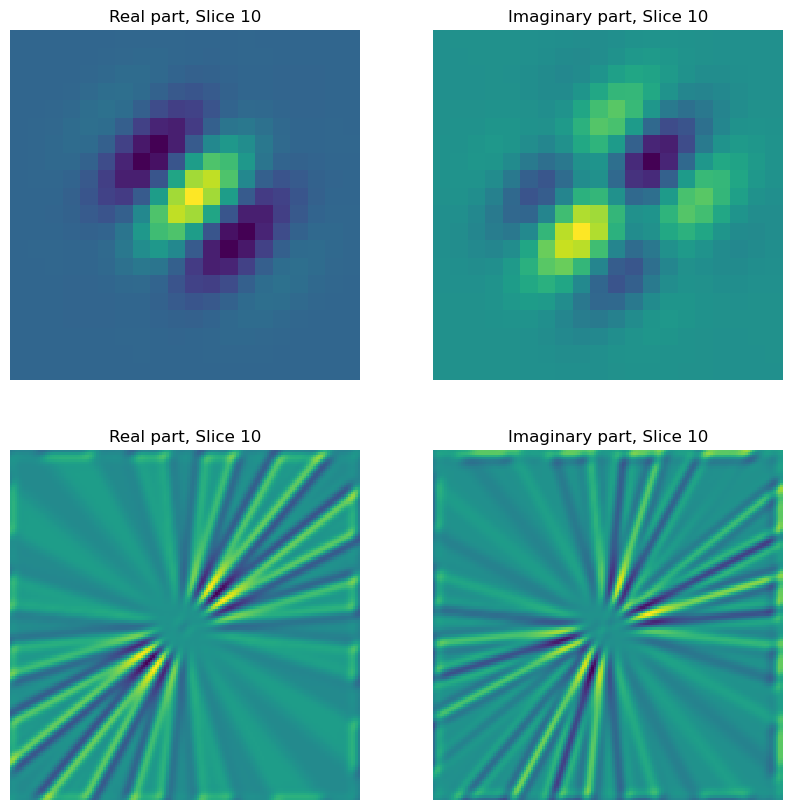

8-0.7853981633974483-0.7853981633974483


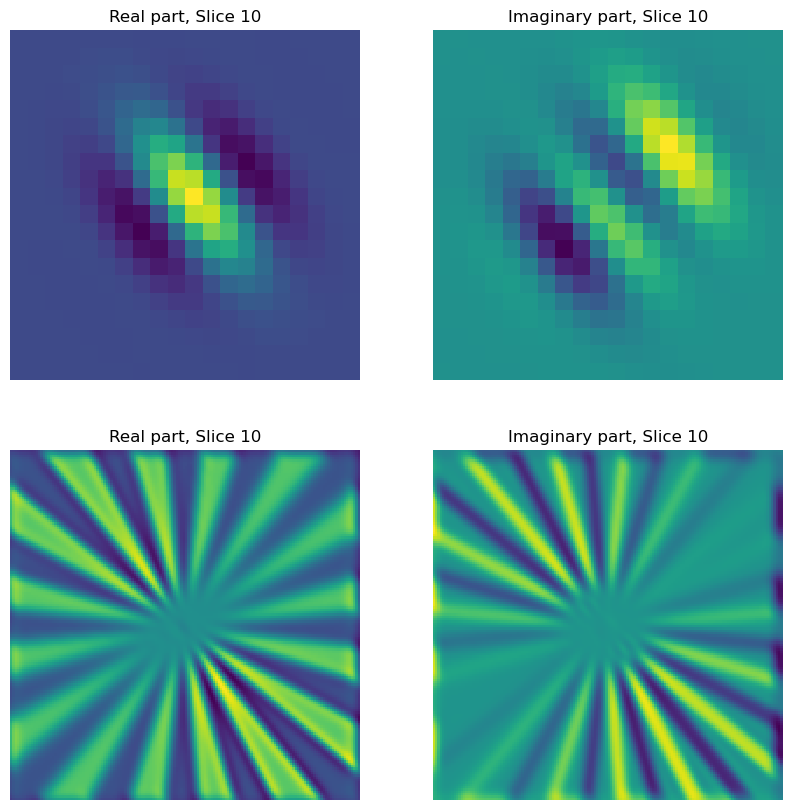

8-0.7853981633974483-1.5707963267948966


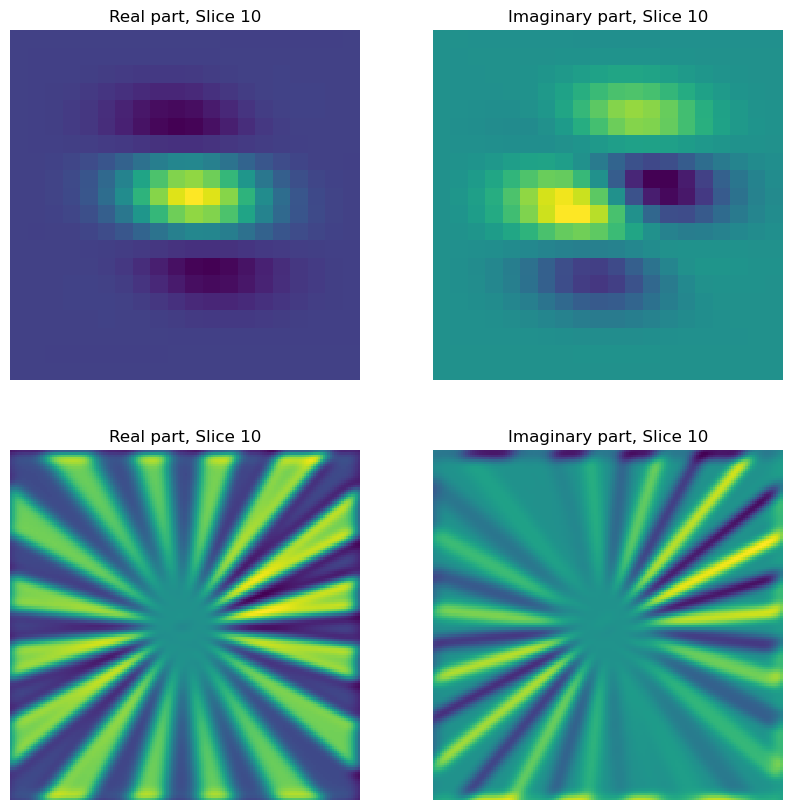

8-0.7853981633974483-2.356194490192345


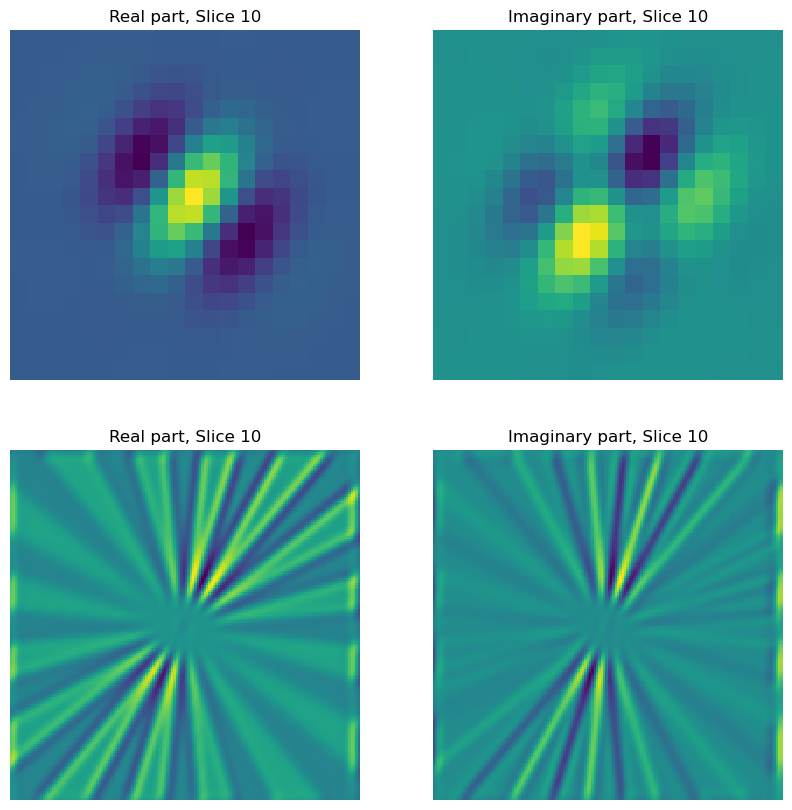

8-1.5707963267948966-0.7853981633974483


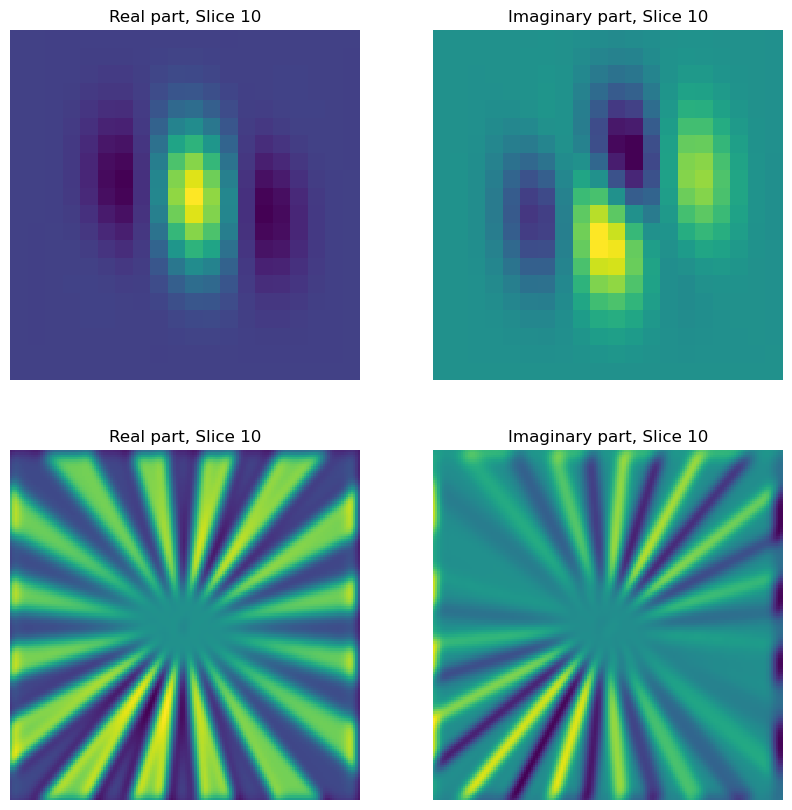

8-1.5707963267948966-1.5707963267948966


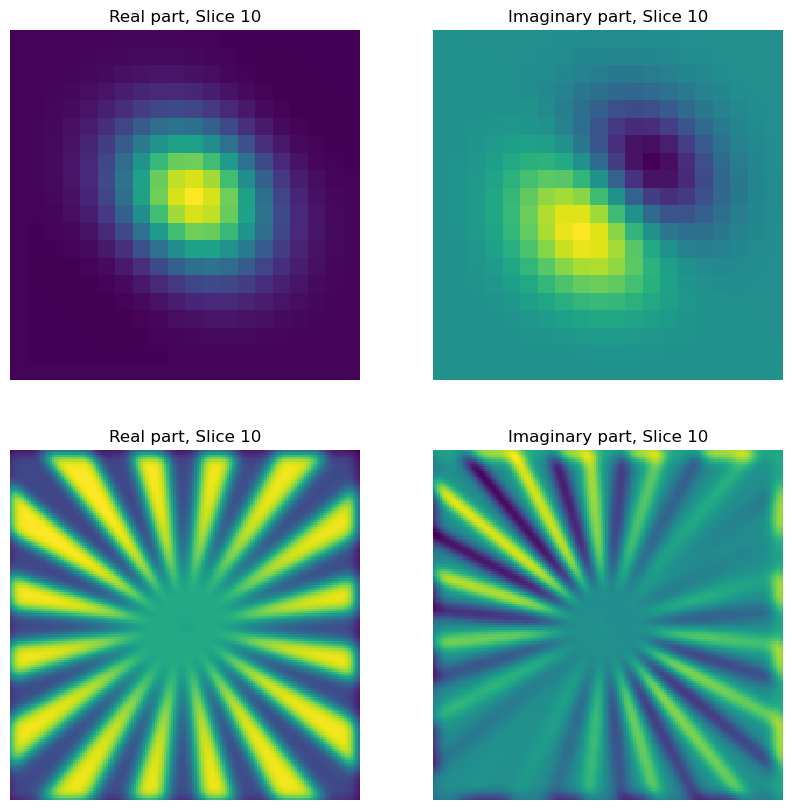

8-1.5707963267948966-2.356194490192345


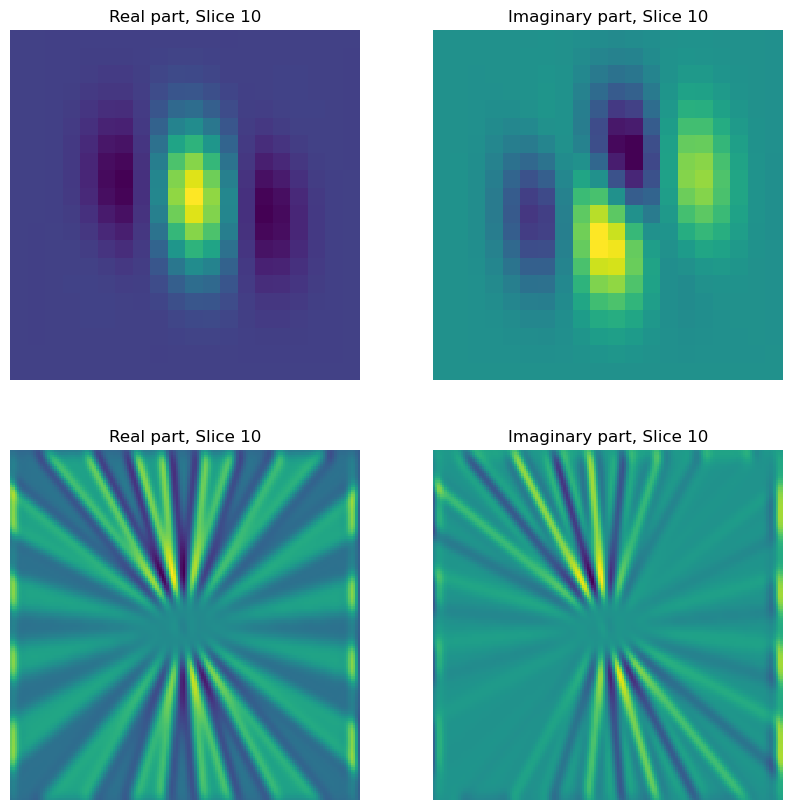

8-2.356194490192345-0.7853981633974483


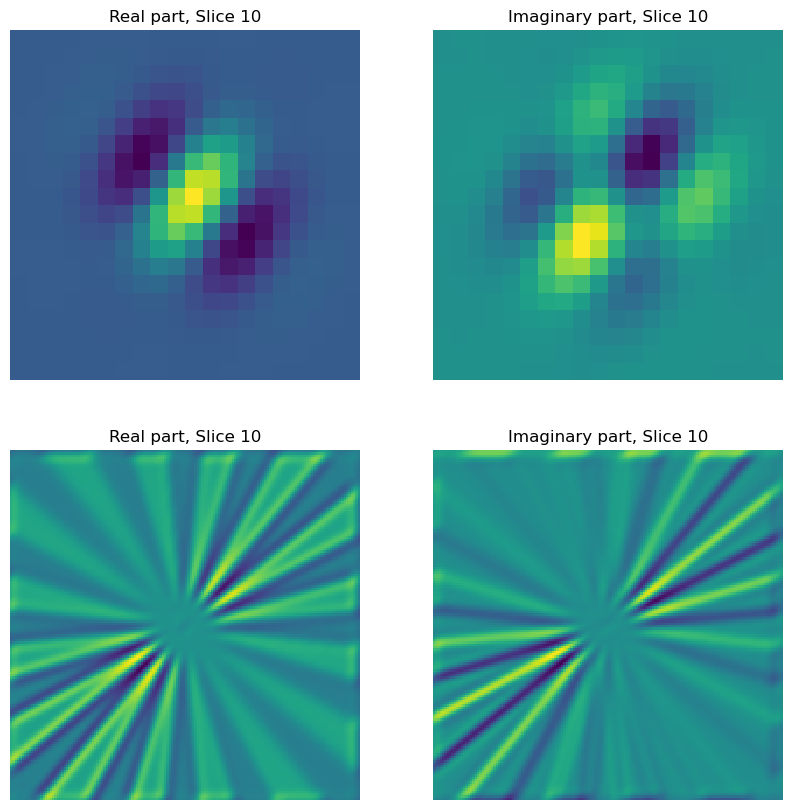

8-2.356194490192345-1.5707963267948966


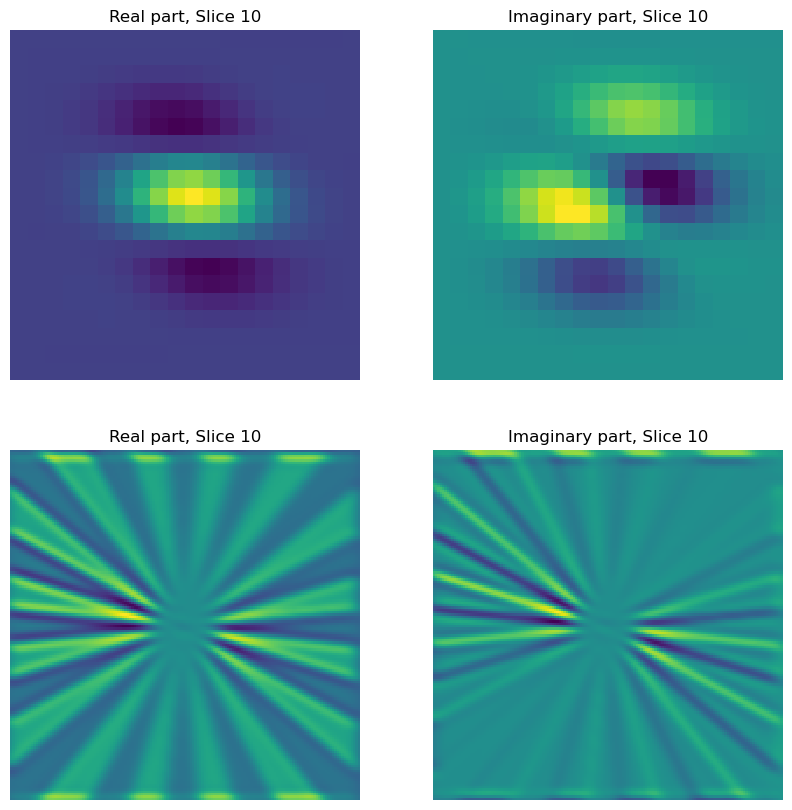

8-2.356194490192345-2.356194490192345


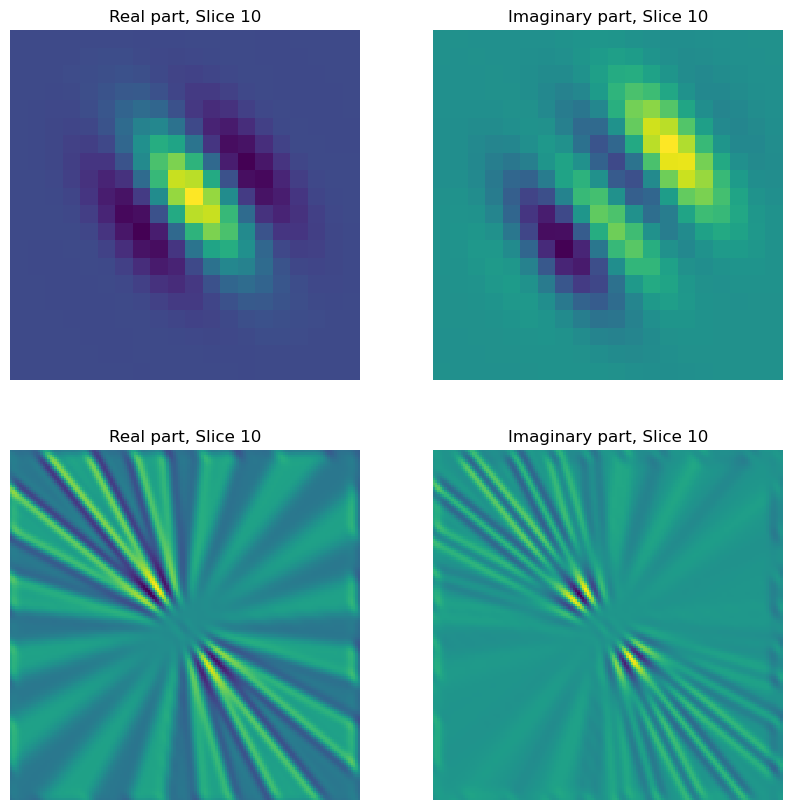

In [18]:
import matplotlib.animation as animation
import os
from IPython.display import Video

# Create output directory
output_dir = f'test_movies_output_norm{normalize}_{filter_banks_size}'
os.makedirs(output_dir, exist_ok=True)

def create_movie(filter_real, filter_imag, output_real, output_imag, filename):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    nslices = nslicestot
    slices = np.linspace(0, nslices-1, nslices, dtype=int)

    def update_plot(frame):
        slice_idx = slices[frame]
        axes[0,0].clear()
        axes[0,1].clear()
        axes[1,0].clear()
        axes[1,1].clear()
        #Filter
        axes[0,0].pcolormesh(filter_real[0,0,slice_idx,:,:])
        axes[0,0].set_aspect('equal')
        axes[0,0].set_title(f'Real part, Slice {slice_idx}')
        axes[0,1].pcolormesh(filter_imag[0,0,slice_idx,:,:])
        axes[0,1].set_aspect('equal')
        axes[0,1].set_title(f'Imaginary part, Slice {slice_idx}')
        #Movie
        axes[1,0].pcolormesh(output_real[0,0,slice_idx,:,:])#, vmin=vmin, vmax=vmax)
        axes[1,0].set_aspect('equal')
        axes[1,0].set_title(f'Real part, Slice {slice_idx}')
        axes[1,1].pcolormesh(output_imag[0,0,slice_idx,:,:])#, vmin=vmin, vmax=vmax)
        axes[1,1].set_aspect('equal')
        axes[1,1].set_title(f'Imaginary part, Slice {slice_idx}')
        for ax in [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]:
            # ax.axhline(0, color='black',linewidth = 0.25) # x = 0
            # ax.axvline(0, color='black',linewidth = 0.25) # y = 0
            ax.axis('off')
        if(frame==nslices//2):
            plt.show()

    ani = animation.FuncAnimation(fig, update_plot, frames=nslices, repeat=False)
    ani.save(filename, writer='ffmpeg', fps=30)
    plt.close(fig)

vmin = np.min((real_outputs.cpu().numpy(), imag_outputs.cpu().numpy()))
vmax = np.max((real_outputs.cpu().numpy(), imag_outputs.cpu().numpy()))

for i in range(len(real_outputs)):

    filter_real = real_filters[i].cpu().numpy()
    filter_imag = imag_filters[i].cpu().numpy()
    output_real = real_outputs[i].cpu().numpy()
    output_imag = imag_outputs[i].cpu().numpy()

    print(filter_names[i])
    #print(output_real.shape)
    #print(output_imag.shape)
    
    filename = os.path.join(output_dir, f'test_response_{filter_names[i]}.mp4')
    create_movie(filter_real, filter_imag, output_real, output_imag, filename)
#show the last video
Video(filename)